In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools

import gensim
import nltk
from nltk.stem import WordNetLemmatizer
np.random.seed(2018)
from nltk.stem.porter import PorterStemmer
from string import punctuation
import pickle
from gensim.models.doc2vec import LabeledSentence
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import confusion_matrix

In [2]:
base_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch'
out_dir='/Volumes/Yuchen_Drive/Insight/OncoMatch/models_lda'
abstract_df=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_df_50930.csv'),index_col='pmid')
cancertype_flattened_df=pickle.load(open(os.path.join(base_dir, "data/cancertype_df2.pkl"),"rb"))

In [18]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [3]:
cancertype_flattened_df.shape

(64853, 2)

In [4]:
abstract_df.shape

(50930, 40)

In [53]:
stop_word1 = gensim.parsing.preprocessing.STOPWORDS   ## 337
stop_word2 = nltk.corpus.stopwords.words('english')   ## 179
punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
custom_words = ["fig", "figure", "et", "al", "al.", "also",
                "data", "analyze", "study", "table", "using",
                "method", "result", "conclusion", "author", 
                "find", "found", "show", '"', "’", "“", "”", 'analysis','analyses','analyzed','results','figures'
                "assayed", "assay", "assays","figures", "figure","data", "sample","samples","table","tables",
                'proteins','protein','cells','cell','genes','gene',
                'mutated','mutation','mutational','mutations','mutate','mutant','mutants',
                'cancer','cancers','tumor','tumors','variant','variants','biology','biological']
stop_words = set(list(stop_word1)+stop_word2+list(punct)+custom_words)   ## 493

In [6]:
pickle.dump(stop_words, open(os.path.join(base_dir, 'data/stop_words_lda.set'),"wb"))

In [7]:
stop_words_lda=pickle.load(open(os.path.join(base_dir, "data/stop_words_lda.set"),"rb"))

In [8]:
print(len(stop_words_lda))

493


In [37]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        temp=WordNetLemmatizer().lemmatize(token).lower()
        if len(temp)>1 and temp not in stop_words:
            result.append(temp)
    return result

In [10]:
abstract_df['abstract_processed']=abstract_df.abstract.apply(lambda x:preprocess(x))

In [342]:
cancertype_flattened_df.cancer_type.value_counts()

Breast Cancer                         7757
Lung Cancer                           5201
Leukemia                              4755
Prostate Cancer                       3878
Colorectal Cancer                     3412
Lymphoma                              2939
Bone Cancer                           2788
Melanoma                              2459
Liver Cancer                          2422
Kidney Cancer                         2262
Ovarian Cancer                        2216
Pancreatic Cancer                     1992
Brain Tumor                           1956
Head and Neck Cancer                  1914
Acute Myeloid Leukemia (AML)          1488
Multiple Myeloma                      1413
Sarcoma                               1407
Bladder Cancer                        1013
Skin Cancer                           1008
Gastric Cancer                         996
Gastrointestinal Tumor                 989
Endometrial Cancer                     962
Acute Lymphoblastic Leukemia (ALL)     903
Chronic Lym

In [6]:
cancer_types=np.array(cancertype_flattened_df.cancer_type.value_counts().index)
print(cancer_types)

['Breast Cancer' 'Lung Cancer' 'Leukemia' 'Prostate Cancer'
 'Colorectal Cancer' 'Lymphoma' 'Bone Cancer' 'Melanoma' 'Liver Cancer'
 'Kidney Cancer' 'Ovarian Cancer' 'Pancreatic Cancer' 'Brain Tumor'
 'Head and Neck Cancer' 'Acute Myeloid Leukemia (AML)' 'Multiple Myeloma'
 'Sarcoma' 'Bladder Cancer' 'Skin Cancer' 'Gastric Cancer'
 'Gastrointestinal Tumor' 'Endometrial Cancer'
 'Acute Lymphoblastic Leukemia (ALL)' 'Chronic Lymphocytic Leukemia (CLL)'
 'Cardiac Tumors' 'Cervical Cancer' 'Esophageal Cancer' 'Thyroid Cancer'
 'Rectal Cancer' 'Myeloproliferative Neoplasms' 'Neuroblastoma'
 'Testicular Cancer' 'Osteosarcoma' 'Chronic Myelogenous Leukemia (CML)'
 'Mesothelioma' 'Ewing Sarcoma' 'Vaginal Cancer' 'Anal Cancer'
 'Retinoblastoma' 'Fallopian Tube Cancer' 'Gallbladder Cancer'
 'Carcinoid Tumor' 'Wilms Tumor' 'Bile Duct Cancer' 'Pituitary Tumor'
 'Burkitt Lymphoma' 'Penile Cancer' 'Rhabdoid Tumor'
 'Adrenocortical Cancer' 'Vulvar Cancer' 'Mycosis Fungoides'
 'Hairy Cell Leukemia' 'P

In [276]:
cancer_type='Breast Cancer'
prefix="_".join(i.lower() for i in cancer_type.split())

In [277]:
subset_df=abstract_df[abstract_df[cancer_type]==1]
subset_df.shape

(8563, 41)

In [278]:
## generate dictionary
bow_dict=gensim.corpora.Dictionary(subset_df.abstract_processed)

In [279]:
bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=100000)
print('len(bow_dict): {}'.format(len(bow_dict)))
bow_dict.save(os.path.join(out_dir, '{}_abstract_bow_dict.dict'.format(cancer_type)))

len(bow_dict): 13055


In [280]:
## generate dictionary for each text file
subset_df['bow_corpus']=subset_df.abstract_processed.apply(lambda x:bow_dict.doc2bow(x))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [281]:
## TF-IDF
tfidf=gensim.models.TfidfModel(list(subset_df.bow_corpus))
bow_tfidf=tfidf[list(subset_df.bow_corpus)]
tfidf.save(os.path.join(out_dir, '{}_abstract_tfidf.tfidf'.format(cancer_type)))
print(len(bow_tfidf))

8563


### Running LDA using TF-IDF

In [177]:
lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=10, id2word=bow_dict, passes=2, workers=4)

In [178]:
lda_model_tfidf.save(os.path.join(out_dir, '{}_abstract_lda.lda'.format(cancer_type)))

In [179]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {}'.format(idx))
    print('Words: {}'.format(topic))
    print('')

Topic: 0
Words: 0.003*"woman" + 0.003*"risk" + 0.003*"brca" + 0.002*"patient" + 0.002*"ci" + 0.002*"cpm" + 0.002*"treatment" + 0.002*"trastuzumab" + 0.002*"survival" + 0.002*"black"

Topic: 1
Words: 0.003*"brca" + 0.003*"patient" + 0.003*"sup" + 0.002*"risk" + 0.002*"survival" + 0.002*"woman" + 0.002*"ctc" + 0.002*"year" + 0.002*"trastuzumab" + 0.002*"chemotherapy"

Topic: 2
Words: 0.003*"er" + 0.003*"patient" + 0.003*"node" + 0.003*"woman" + 0.002*"risk" + 0.002*"positive" + 0.002*"chemotherapy" + 0.002*"lrr" + 0.002*"ci" + 0.002*"therapy"

Topic: 3
Words: 0.003*"patient" + 0.002*"ci" + 0.002*"survival" + 0.002*"risk" + 0.002*"woman" + 0.002*"year" + 0.002*"therapy" + 0.002*"month" + 0.002*"treatment" + 0.002*"response"

Topic: 4
Words: 0.003*"dci" + 0.002*"margin" + 0.002*"patient" + 0.002*"risk" + 0.002*"therapy" + 0.002*"woman" + 0.002*"rt" + 0.002*"year" + 0.002*"surgery" + 0.002*"treatment"

Topic: 5
Words: 0.002*"risk" + 0.002*"woman" + 0.002*"patient" + 0.002*"expression" + 0.0

In [181]:
vector = lda_model_tfidf[bow_tfidf]
ldavector = gensim.matutils.corpus2csc(vector)
ldavector = ldavector.T.toarray()
print(ldavector.shape)
ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(10)])
ldavector_df['pred']=ldavector_df.idxmax(axis=1)
ldavector_df.index=subset_df.index
ldavector_df.head()

(8340, 10)


,topic0,topic1,topic2,topic3,topic4,topic5,topic6,topic7,topic8,topic9,pred
pmid,,,,,,,,,,,
11773149,0.013167,0.013167,0.881498,0.013167,0.013167,0.013166,0.013167,0.013167,0.013167,0.013168,topic2
11782367,0.012775,0.012775,0.012775,0.012775,0.012774,0.012777,0.885025,0.012775,0.012775,0.012774,topic6
11786581,0.014564,0.014564,0.014557,0.868937,0.014557,0.014558,0.014576,0.014566,0.014561,0.014560,topic3
11790564,0.015148,0.015148,0.015149,0.015148,0.015146,0.015148,0.015148,0.863671,0.015147,0.015147,topic7
11792833,0.013623,0.013622,0.877397,0.013622,0.013621,0.013622,0.013628,0.013622,0.013622,0.013622,topic2


In [182]:
pickle.dump(ldavector_df, open(os.path.join(out_dir, '{}_abstract_ldavector_df.pkl'.format(prefix)),"wb"))

In [183]:
ldavector_df.pred.value_counts()

topic2    1550
topic3    1406
topic9    1152
topic1     990
topic6     735
topic0     691
topic8     683
topic5     391
topic7     390
topic4     352
Name: pred, dtype: int64

In [111]:
query='The patient has BRCA mutant breast cancer with a family history of breast and ovarian cancer.'
query_preprocess=preprocess(query)

In [184]:
bow_dict=gensim.corpora.Dictionary.load(os.path.join(out_dir, '{}_abstract_bow_dict.dict'.format(cancer_type)))
tfidf=gensim.models.TfidfModel.load(os.path.join(out_dir, '{}_abstract_tfidf.tfidf'.format(cancer_type)))
lda = gensim.models.LdaMulticore.load(os.path.join(out_dir, '{}_abstract_lda.lda'.format(cancer_type)))

query_corpus=[bow_dict.doc2bow(query_preprocess)]
query_tfidf=tfidf[query_corpus]
query_lda=lda[query_tfidf]
query_lda = gensim.matutils.corpus2csc(query_lda)
query_lda = query_lda.T.toarray()

In [28]:
def lda_query(query,prefix):
    query_preprocess=preprocess(query)
    bow_dict=gensim.corpora.Dictionary.load(os.path.join(out_dir, '{}_abstract_bow_dict.dict'.format(prefix)))
    tfidf=gensim.models.TfidfModel.load(os.path.join(out_dir, '{}_abstract_tfidf.tfidf'.format(prefix)))
    lda = gensim.models.LdaMulticore.load(os.path.join(out_dir, '{}_abstract_lda.lda'.format(prefix)))

    query_corpus=[bow_dict.doc2bow(query_preprocess)]
    query_tfidf=tfidf[query_corpus]
    query_lda=lda[query_tfidf]
    query_lda = gensim.matutils.corpus2csc(query_lda)
    query_lda = query_lda.T.toarray()
    #np.argmax(query_lda)
    return np.argsort(query_lda).squeeze()

In [186]:
subset_df['abstract_lda_pred']=ldavector_df.pred
subset_df['abstract_lda_pred']=subset_df.abstract_lda_pred.apply(lambda x:int(x[5:]))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [187]:
# title_array = np.arange(10).reshape(1,-1)
# np.concatenate((query_lda, query_lda2)).shape
subset_df['title_lda_preds']=subset_df.article_title.apply(lambda x:lda_query(x,predix))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [188]:
subset_df['title_lda_pred1']=subset_df.title_lda_preds.apply(lambda x:x[-1])
subset_df['title_lda_pred2']=subset_df.title_lda_preds.apply(lambda x:x[-2])
subset_df['title_lda_pred3']=subset_df.title_lda_preds.apply(lambda x:x[-3])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [189]:
pred1_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred1).sum()
pred2_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred2).sum()
pred3_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred3).sum()
print('pred1_match: {}'.format(pred1_match))
print('pred2_match: {}'.format(pred2_match))
print('pred3_match: {}'.format(pred3_match))
print('Top 3 topics match rate: {}'.format((pred1_match+pred2_match+pred3_match)/subset_df.shape[0]))

pred1_match: 3710
pred2_match: 1531
pred3_match: 963
Top 3 topics match rate: 0.7438848920863309


In [120]:
def plot_confusion_matrix(cm, classes,title='Confusion matrix',cmap=plt.cm.Blues):    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=12)
    plt.colorbar(shrink=0.8)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12, fontweight='bold')
    plt.yticks(tick_marks, classes, fontsize=12, fontweight='bold')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{:d} \n({:.2f}%)'.format(cm[i, j], cm[i,j]/cm.sum()*100), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.tight_layout()

In [197]:
def plot_acc_bar(cm,title=''):
    acc=[cm[i][i] for i in range(len(classes))]
    acc_freq=acc/cm.sum(axis=1)
    fig = plt.figure(figsize = (10,6))
    ax = fig.add_subplot(1,1,1)
    width = 0.75 # the width of the bars 
    ind = np.arange(len(classes))  # the x locations for the groups
    ax.bar(ind, np.round(acc_freq*100,2), width, edgecolor='black', color = sns.color_palette('hls', len(classes)))
    plt.xticks(ind, labels = classes, fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.ylim(0,110)
    plt.xlabel('Category', fontsize=12)
    plt.ylabel('Accuracy%', fontsize=12)
    for i, v in enumerate(np.round(acc_freq*100,2)):
        ax.text(i-0.35, v + 1, str(np.round(v,2))+'%', fontsize=12)
    plt.title(title)

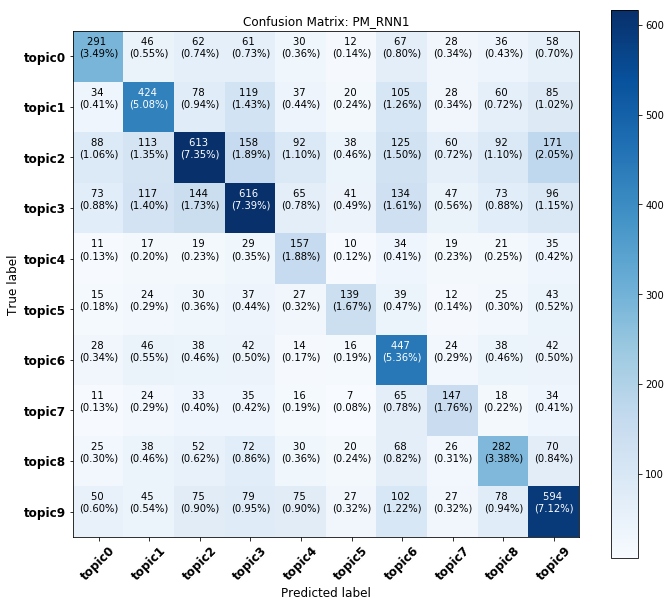

In [190]:
cm = confusion_matrix(subset_df.abstract_lda_pred, subset_df.title_lda_pred1)
classes = np.array(['topic'+str(i) for i in np.arange(10)])
plot_confusion_matrix(cm, classes, title = 'Confusion Matrix: PM_RNN1', cmap=plt.cm.Blues)

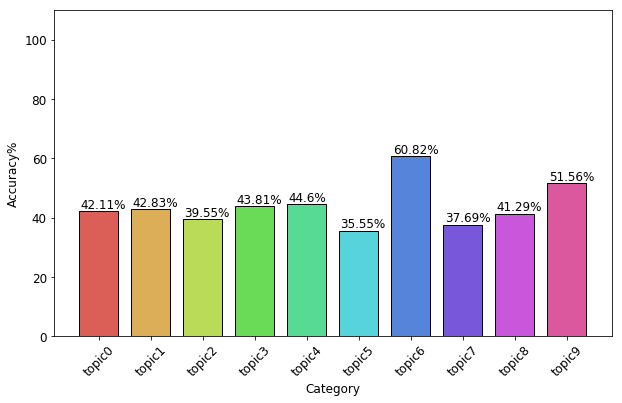

In [198]:
plot_acc_bar(cm,title='')

### Combined function LDA: num_topics=10

In [81]:
pmid_num_dict = {}
bow_dict_len_dict = {}
pred1_match_dict = {}
pred2_match_dict = {}
pred3_match_dict = {}
top1_match_dict = {}
top3_match_dict = {}

In [82]:
def lda_by_cancertype(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid_list = cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid_list]
    print('subset_df: {}'.format(subset_df.shape))
    pmid_num_dict[cancer_type]=subset_df.shape[0]
    ## generate dictionary
    bow_dict=gensim.corpora.Dictionary(subset_df.abstract_processed)
    bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=100000)
    print('{}_len(bow_dict): {}'.format(prefix, len(bow_dict)))
    bow_dict.save(os.path.join(base_dir, 'models_lda/{}_abstract_bow_dict.dict'.format(prefix)))
    bow_dict_len_dict[cancer_type]=len(bow_dict)
    ## generate dictionary for each text file
    subset_df['bow_corpus']=subset_df.abstract_processed.apply(lambda x:bow_dict.doc2bow(x))
    ## TF-IDF
    tfidf=gensim.models.TfidfModel(list(subset_df.bow_corpus))
    bow_tfidf=tfidf[list(subset_df.bow_corpus)]
    tfidf.save(os.path.join(base_dir, 'models_lda/{}_abstract_tfidf.tfidf'.format(prefix)))
    print(len(bow_tfidf))
    lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=10, id2word=bow_dict, passes=2, workers=4)
    lda_model_tfidf.save(os.path.join(base_dir, 'models_lda/{}_abstract_lda.lda'.format(prefix)))
    vector = lda_model_tfidf[bow_tfidf]
    ldavector = gensim.matutils.corpus2csc(vector)
    ldavector = ldavector.T.toarray()
    print(ldavector.shape)
    ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(10)])
    ldavector_df['pred']=ldavector_df.idxmax(axis=1)
    ldavector_df.index=subset_df.index
    pickle.dump(ldavector_df, open(os.path.join(base_dir, 'models_lda/{}_abstract_ldavector_df.pkl'.format(prefix)),"wb"))
    ldavector_df.to_csv(os.path.join(base_dir, "models_lda/{}_abstract_ldavector_df.csv".format(prefix)),index=True,index_label='pmid')
    
    subset_df['abstract_lda_pred']=ldavector_df.pred
    subset_df['abstract_lda_pred']=subset_df.abstract_lda_pred.apply(lambda x:int(x[5:]))
    subset_df['title_lda_preds']=subset_df.article_title.apply(lambda x:lda_query(x,prefix))
    subset_df['title_lda_pred1']=subset_df.title_lda_preds.apply(lambda x:x[-1])
    subset_df['title_lda_pred2']=subset_df.title_lda_preds.apply(lambda x:x[-2])
    subset_df['title_lda_pred3']=subset_df.title_lda_preds.apply(lambda x:x[-3])
    
    pred1_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred1).sum()
    pred2_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred2).sum()
    pred3_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred3).sum()
    top1_match_rate=pred1_match/subset_df.shape[0]
    top3_match_rate=(pred1_match+pred2_match+pred3_match)/subset_df.shape[0]
    print('pred1_match: {}'.format(pred1_match))
    print('pred2_match: {}'.format(pred2_match))
    print('pred3_match: {}'.format(pred3_match))
    print('Top 1 topic match rate: {}'.format(top1_match_rate))
    print('Top 3 topics match rate: {}'.format(top3_match_rate))
    pred1_match_dict[cancer_type]=pred1_match
    pred2_match_dict[cancer_type]=pred2_match
    pred3_match_dict[cancer_type]=pred3_match
    top1_match_dict[cancer_type]=top1_match_rate
    top3_match_dict[cancer_type]=top3_match_rate
    print('-'*30)

In [83]:
cancer2pmid_dict=pickle.load(open(os.path.join(base_dir, "data/cancer2pmid_dict.pkl"),"rb"))

In [ ]:
for cancer_type in cancer_types:
    print(cancer_type)
    lda_by_cancertype(cancer_type)

In [379]:
df1 = pd.DataFrame.from_dict(pmid_num_dict, orient='index', columns=['pmid_num'])
df2 = pd.DataFrame.from_dict(bow_dict_len_dict, orient='index', columns=['bow_dict_len'])
df3 = pd.DataFrame.from_dict(pred1_match_dict, orient='index', columns=['pred1_match'])
df4 = pd.DataFrame.from_dict(pred2_match_dict, orient='index', columns=['pred2_match'])
df5 = pd.DataFrame.from_dict(pred3_match_dict, orient='index', columns=['pred3_match'])
df6 = pd.DataFrame.from_dict(top1_match_dict, orient='index', columns=['top1_match'])
df7 = pd.DataFrame.from_dict(top3_match_dict, orient='index', columns=['top3_match'])

In [380]:
lda_summary_df=pd.concat([df1,df2,df3,df4,df5,df6,df7],axis=1,sort=False)

In [381]:
lda_summary_df.shape

(55, 7)

In [382]:
lda_summary_df.to_csv(os.path.join(base_dir, "models_lda/lda_summary.csv"),index=True, index_label="cancer_type")

In [383]:
lda_summary_df=pd.read_csv(os.path.join(base_dir, "models_lda/lda_summary.csv"), index_col="cancer_type")

In [384]:
lda_summary_df.head()

,pmid_num,bow_dict_len,pred1_match,pred2_match,pred3_match,top1_match,top3_match
cancer_type,,,,,,,
Breast Cancer,8563,13055,3869,1561,959,0.451828,0.746117
Lung Cancer,5518,10725,2433,915,644,0.440921,0.723451
Leukemia,4962,9485,2481,1006,566,0.500000,0.816808
Prostate Cancer,4018,9376,1843,692,491,0.458686,0.753111
Colorectal Cancer,3611,8737,1747,568,395,0.483800,0.750485


### Combined function LDA: num_topics=20

In [85]:
pmid_num_dict = {}
bow_dict_len_dict = {}
pred1_match_dict = {}
pred2_match_dict = {}
pred3_match_dict = {}
pred4_match_dict = {}
pred5_match_dict = {}
pred6_match_dict = {}
top1_match_dict = {}
top2_match_dict = {}
top3_match_dict = {}
top4_match_dict = {}
top5_match_dict = {}
top6_match_dict = {}

In [86]:
def lda_by_cancertype20(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid_list = cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid_list]
    print('subset_df: {}'.format(subset_df.shape))
    pmid_num_dict[cancer_type]=subset_df.shape[0]
    ## generate dictionary
    bow_dict=gensim.corpora.Dictionary(subset_df.abstract_processed)
    bow_dict.filter_extremes(no_below=2, no_above=0.8, keep_n=100000)
    print('{}_len(bow_dict): {}'.format(prefix, len(bow_dict)))
    #bow_dict.save(os.path.join(base_dir, 'models_lda/{}_abstract_bow_dict.dict'.format(prefix)))
    bow_dict_len_dict[cancer_type]=len(bow_dict)
    ## generate dictionary for each text file
    subset_df['bow_corpus']=subset_df.abstract_processed.apply(lambda x:bow_dict.doc2bow(x))
    ## TF-IDF
    tfidf=gensim.models.TfidfModel(list(subset_df.bow_corpus))
    bow_tfidf=tfidf[list(subset_df.bow_corpus)]
    #tfidf.save(os.path.join(base_dir, 'models_lda/{}_abstract_tfidf.tfidf'.format(prefix)))
    print(len(bow_tfidf))
    lda_model_tfidf=gensim.models.LdaMulticore(bow_tfidf, num_topics=20, id2word=bow_dict, passes=2, workers=4)
    lda_model_tfidf.save(os.path.join(base_dir, 'models_lda/{}_abstract_lda20.lda'.format(prefix)))
    vector = lda_model_tfidf[bow_tfidf]
    ldavector = gensim.matutils.corpus2csc(vector)
    ldavector = ldavector.T.toarray()
    print(ldavector.shape)
    ldavector_df=pd.DataFrame(ldavector,columns=['topic{}'.format(i) for i in range(20)])
    ldavector_df['pred']=ldavector_df.idxmax(axis=1)
    ldavector_df.index=subset_df.index
    pickle.dump(ldavector_df, open(os.path.join(base_dir, 'models_lda/{}_abstract_ldavector20_df.pkl'.format(prefix)),"wb"))
    ldavector_df.to_csv(os.path.join(base_dir, "models_lda/{}_abstract_ldavector20_df.csv".format(prefix)),index=True,index_label='pmid')
    
    subset_df['abstract_lda_pred']=ldavector_df.pred
    subset_df['abstract_lda_pred']=subset_df.abstract_lda_pred.apply(lambda x:int(x[5:]))
    subset_df['title_lda_preds']=subset_df.article_title.apply(lambda x:lda_query(x,prefix))
    subset_df['title_lda_pred1']=subset_df.title_lda_preds.apply(lambda x:x[-1])
    subset_df['title_lda_pred2']=subset_df.title_lda_preds.apply(lambda x:x[-2])
    subset_df['title_lda_pred3']=subset_df.title_lda_preds.apply(lambda x:x[-3])
    subset_df['title_lda_pred4']=subset_df.title_lda_preds.apply(lambda x:x[-4])
    subset_df['title_lda_pred5']=subset_df.title_lda_preds.apply(lambda x:x[-5])
    subset_df['title_lda_pred6']=subset_df.title_lda_preds.apply(lambda x:x[-6])
    
    pred1_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred1).sum()
    pred2_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred2).sum()
    pred3_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred3).sum()
    pred4_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred4).sum()
    pred5_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred5).sum()
    pred6_match=(subset_df.abstract_lda_pred==subset_df.title_lda_pred6).sum()
    
    top1_match_rate=pred1_match/subset_df.shape[0]
    top2_match_rate=(pred1_match+pred2_match)/subset_df.shape[0]
    top3_match_rate=(pred1_match+pred2_match+pred3_match)/subset_df.shape[0]
    top4_match_rate=(pred1_match+pred2_match+pred3_match+pred4_match)/subset_df.shape[0]
    top5_match_rate=(pred1_match+pred2_match+pred3_match+pred4_match+pred5_match)/subset_df.shape[0]
    top6_match_rate=(pred1_match+pred2_match+pred3_match+pred4_match+pred5_match+pred6_match)/subset_df.shape[0]
    print('pred1_match: {}'.format(pred1_match))
    print('pred2_match: {}'.format(pred2_match))
    print('pred3_match: {}'.format(pred3_match))
    print('Top 1 topic match rate: {}'.format(top1_match_rate))
    print('Top 3 topics match rate: {}'.format(top3_match_rate))
    print('Top 6 topics match rate: {}'.format(top6_match_rate))
    pred1_match_dict[cancer_type]=pred1_match
    pred2_match_dict[cancer_type]=pred2_match
    pred3_match_dict[cancer_type]=pred3_match
    pred4_match_dict[cancer_type]=pred4_match
    pred5_match_dict[cancer_type]=pred5_match
    pred6_match_dict[cancer_type]=pred6_match
    top1_match_dict[cancer_type]=top1_match_rate
    top2_match_dict[cancer_type]=top2_match_rate
    top3_match_dict[cancer_type]=top3_match_rate
    top4_match_dict[cancer_type]=top4_match_rate
    top5_match_dict[cancer_type]=top5_match_rate
    top6_match_dict[cancer_type]=top6_match_rate
    print('-'*30)

In [87]:
for cancer_type in cancer_types:
    print(cancer_type)
    lda_by_cancertype20(cancer_type)

Breast Cancer
subset_df: (8563, 42)
breast_cancer_len(bow_dict): 13055
8563
(8563, 20)
pred1_match: 389
pred2_match: 387
pred3_match: 379
Top 1 topic match rate: 0.045428004204134065
Top 3 topics match rate: 0.13488263459068084
Top 6 topics match rate: 0.2833119233913348
------------------------------
Lung Cancer
subset_df: (5518, 42)
lung_cancer_len(bow_dict): 10725
5518
(5518, 20)
pred1_match: 192
pred2_match: 222
pred3_match: 210
Top 1 topic match rate: 0.034795215657847045
Top 3 topics match rate: 0.1130844508880029
Top 6 topics match rate: 0.21855744835085175
------------------------------
Leukemia
subset_df: (4962, 42)
leukemia_len(bow_dict): 9485
4962
(4962, 20)
pred1_match: 143
pred2_match: 146
pred3_match: 155
Top 1 topic match rate: 0.028819024586860136
Top 3 topics match rate: 0.08948004836759371
Top 6 topics match rate: 0.1989117291414752
------------------------------
Prostate Cancer
subset_df: (4018, 42)
prostate_cancer_len(bow_dict): 9376
4018
(4018, 20)
pred1_match: 188

708
(708, 20)
pred1_match: 28
pred2_match: 48
pred3_match: 35
Top 1 topic match rate: 0.03954802259887006
Top 3 topics match rate: 0.15677966101694915
Top 6 topics match rate: 0.3389830508474576
------------------------------
Rectal Cancer
subset_df: (668, 42)
rectal_cancer_len(bow_dict): 3587
668
(668, 20)
pred1_match: 16
pred2_match: 16
pred3_match: 10
Top 1 topic match rate: 0.023952095808383235
Top 3 topics match rate: 0.06287425149700598
Top 6 topics match rate: 0.15269461077844312
------------------------------
Myeloproliferative Neoplasms
subset_df: (573, 42)
myeloproliferative_neoplasms_len(bow_dict): 3055
573
(573, 20)
pred1_match: 32
pred2_match: 20
pred3_match: 18
Top 1 topic match rate: 0.055846422338568937
Top 3 topics match rate: 0.12216404886561955
Top 6 topics match rate: 0.2268760907504363
------------------------------
Neuroblastoma
subset_df: (368, 42)
neuroblastoma_len(bow_dict): 2813
368
(368, 20)
pred1_match: 19
pred2_match: 24
pred3_match: 18
Top 1 topic match ra

### Rank similarity scores in each cancer_type

In [22]:
from doctor_recommendation import Oncomatch_model

In [24]:
def get_similarity_rank(cancer_type, text, pmid):
    similarity_df = Oncomatch_model(cancer_type).get_similarity_scores(text)
    return int(similarity_df.index[similarity_df.pmid==pmid].values)

In [25]:
abstract_df['pmid'] = abstract_df.index
cancer_type = "Appendix Cancer"
print(cancer_type)
prefix="_".join(i.lower() for i in cancer_type.split())
pmid_list = cancer2pmid_dict[cancer_type]
subset_df=abstract_df.loc[pmid_list]
subset_df['lda_similarity_rank_{}'.format(prefix)] = subset_df.apply(lambda x:get_similarity_rank(cancer_type, x.article_title, x.pmid),axis=1)
subset_df['lda_similarity_rank_{}_percentile'.format(prefix)] = subset_df['lda_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
subset_df.to_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)),index=False)

Appendix Cancer


In [403]:
subset_df.columns

Index(['article_title', 'journal_title', 'journal_abbre', 'article_date',
       'abstract', 'article_type', 'pub_days', 'citation', 'abstract_clean',
       'Breast Cancer', 'Lung Cancer', 'Leukemia', 'Prostate Cancer',
       'Colorectal Cancer', 'Lymphoma', 'Bone Cancer', 'Melanoma',
       'Liver Cancer', 'Kidney Cancer', 'Ovarian Cancer', 'Pancreatic Cancer',
       'Brain Tumor', 'Head and Neck Cancer', 'Acute Myeloid Leukemia (AML)',
       'Multiple Myeloma', 'Sarcoma', 'Bladder Cancer', 'Skin Cancer',
       'Gastric Cancer', 'Gastrointestinal Tumor', 'Endometrial Cancer',
       'Acute Lymphoblastic Leukemia (ALL)',
       'Chronic Lymphocytic Leukemia (CLL)', 'Cardiac Tumors',
       'Cervical Cancer', 'Esophageal Cancer', 'Thyroid Cancer',
       'Rectal Cancer', 'text_clean_seq', 'text_length', 'abstract_processed',
       'pmid'],
      dtype='object')

In [27]:
abstract_df['pmid'] = abstract_df.index
for cancer_type in cancer_types:
    print(cancer_type)
    prefix="_".join(i.lower() for i in cancer_type.split())
    pmid_list = cancer2pmid_dict[cancer_type]
    subset_df=abstract_df.loc[pmid_list]
    subset_df['lda_similarity_rank_{}'.format(prefix)] = subset_df.apply(lambda x:get_similarity_rank(cancer_type, x.article_title, x.pmid),axis=1)
    subset_df['lda_similarity_rank_{}_percentile'.format(prefix)] = subset_df['lda_similarity_rank_{}'.format(prefix)]/subset_df.shape[0]
    subset_df.to_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)),index=False)

Breast Cancer
Lung Cancer
Leukemia
Prostate Cancer
Colorectal Cancer
Lymphoma
Bone Cancer
Melanoma
Liver Cancer
Kidney Cancer
Ovarian Cancer
Pancreatic Cancer
Brain Tumor
Head and Neck Cancer
Acute Myeloid Leukemia (AML)
Multiple Myeloma
Sarcoma
Bladder Cancer
Skin Cancer
Gastric Cancer
Gastrointestinal Tumor
Endometrial Cancer
Acute Lymphoblastic Leukemia (ALL)
Chronic Lymphocytic Leukemia (CLL)
Cardiac Tumors
Cervical Cancer
Esophageal Cancer
Thyroid Cancer
Rectal Cancer
Myeloproliferative Neoplasms
Neuroblastoma
Testicular Cancer
Osteosarcoma
Chronic Myelogenous Leukemia (CML)
Mesothelioma
Ewing Sarcoma
Vaginal Cancer
Anal Cancer
Retinoblastoma
Fallopian Tube Cancer
Gallbladder Cancer
Carcinoid Tumor
Wilms Tumor
Bile Duct Cancer
Pituitary Tumor
Burkitt Lymphoma
Penile Cancer
Rhabdoid Tumor
Adrenocortical Cancer
Vulvar Cancer
Mycosis Fungoides
Hairy Cell Leukemia
Parathyroid Cancer
Urethral Cancer
Appendix Cancer


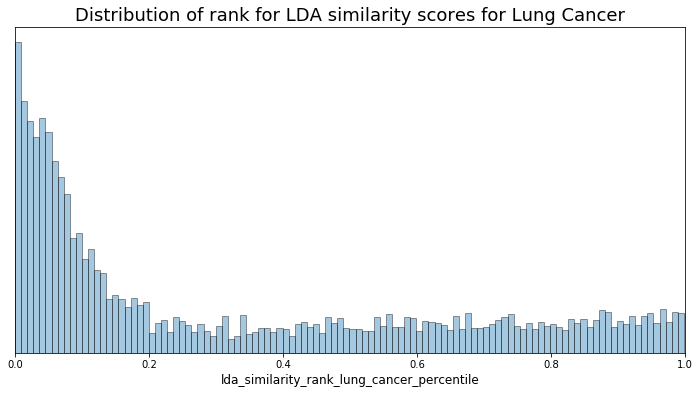

In [42]:
cancer_type = "Lung Cancer"
prefix="_".join(i.lower() for i in cancer_type.split())
subset_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))

fig,ax=plt.subplots(1,1,figsize=(12,6))
sns.distplot(subset_df['lda_similarity_rank_{}_percentile'.format(prefix)], hist=True,kde=False,bins=int(subset_df.shape[0]/50),ax=ax,hist_kws={'edgecolor':'black'})
ax.set_xlim(0,1)
ax.set_xlabel('lda_similarity_rank_{}_percentile'.format(prefix), fontsize=12)
ax.set_yticks([])
ax.set_title('Distribution of rank for LDA similarity scores for {}'.format(cancer_type), fontsize=18)
plt.show()
fig.savefig(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.png'.format(prefix)))

In [49]:
def plot_lda_similarity_rank(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))

    fig,ax=plt.subplots(1,1,figsize=(12,6))
    sns.distplot(subset_df['lda_similarity_rank_{}_percentile'.format(prefix)], hist=True,kde=False,bins=int(subset_df.shape[0]/50) if subset_df.shape[0]>1000 else 20,ax=ax,hist_kws={'edgecolor':'black'})
    ax.set_xlim(0,1)
    ax.set_xlabel('lda_similarity_score_rank_percentile_{}'.format(prefix), fontsize=12)
    ax.set_yticks([])
    ax.set_title('Distribution of LDA similarity score rank for {}'.format(cancer_type), fontsize=18)
    plt.show()
    fig.savefig(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.png'.format(prefix)))

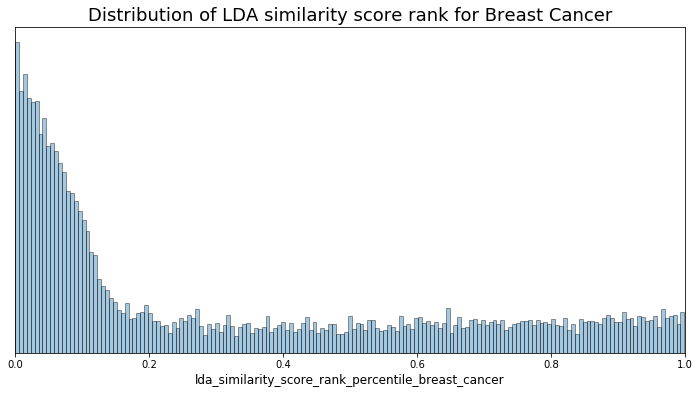

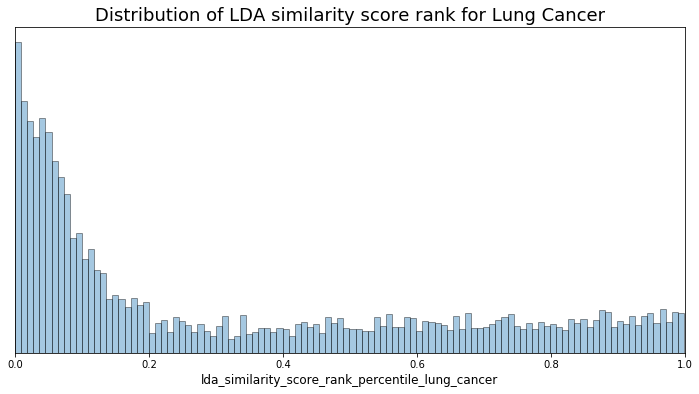

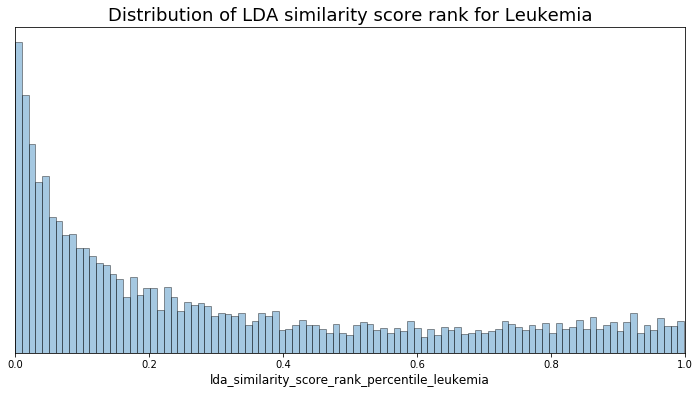

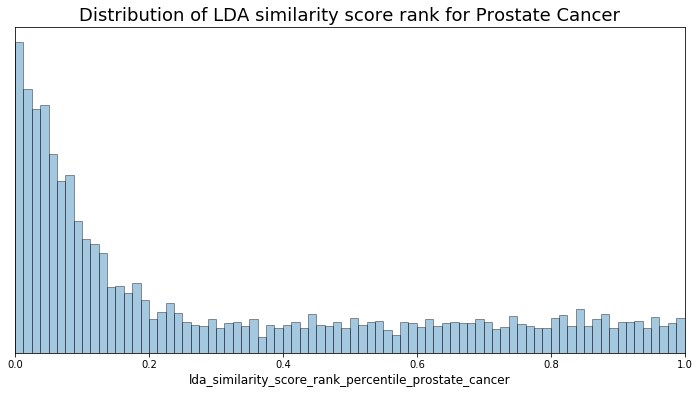

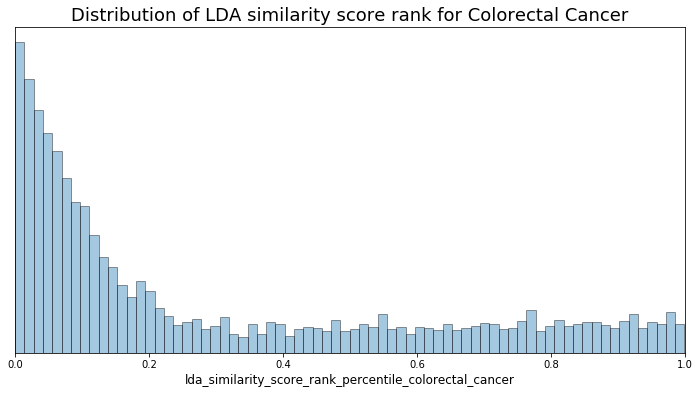

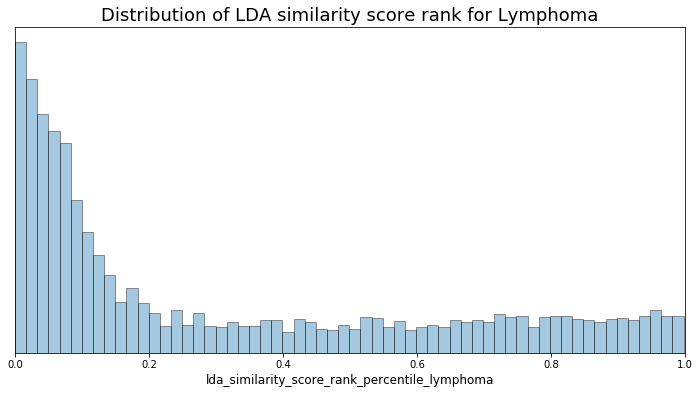

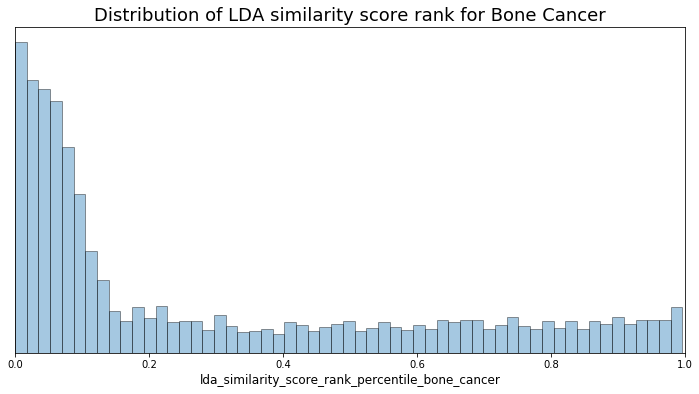

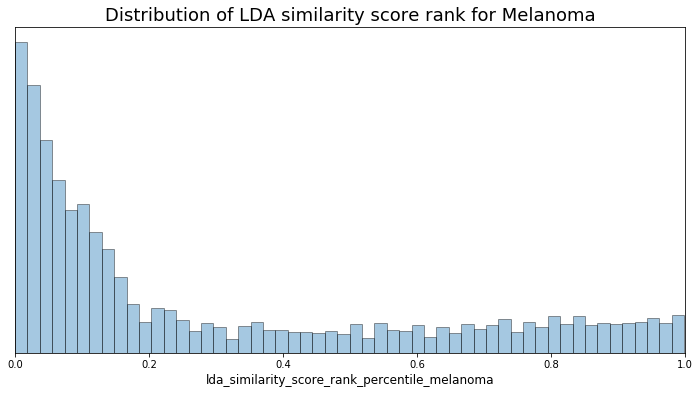

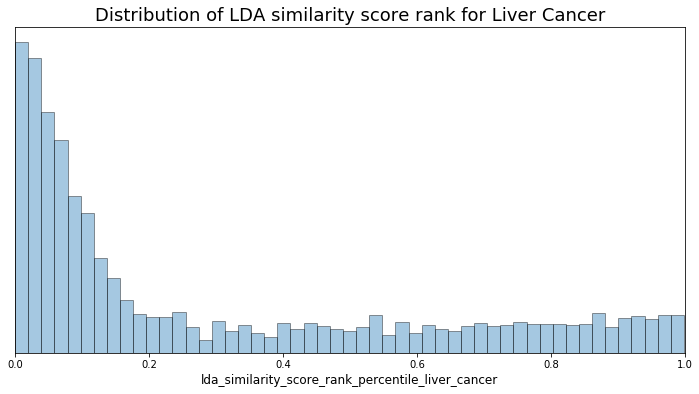

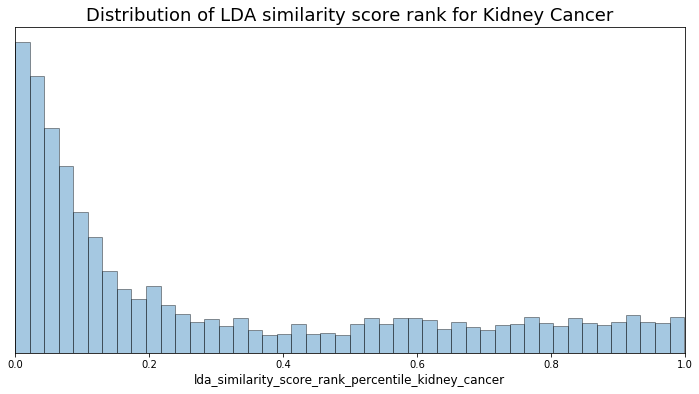

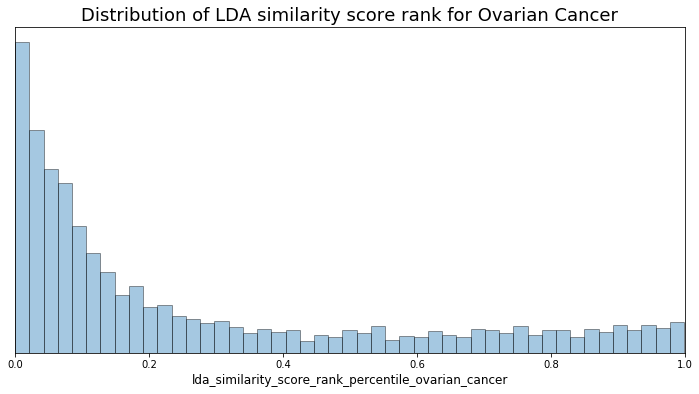

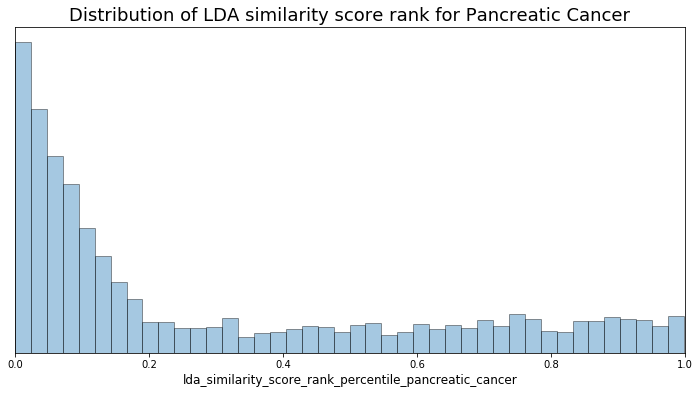

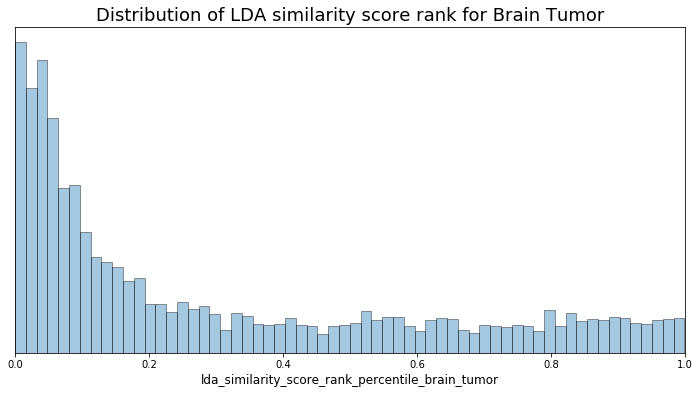

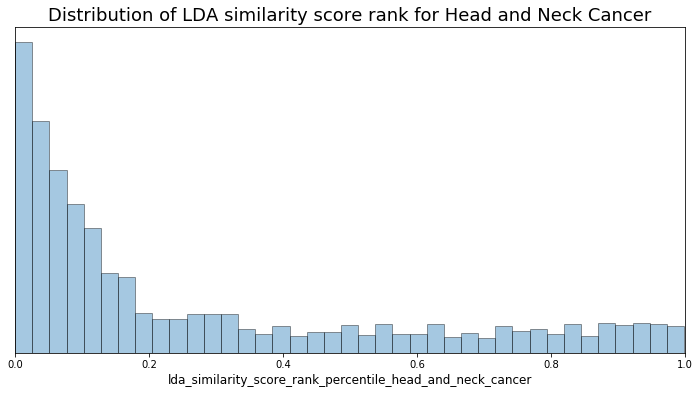

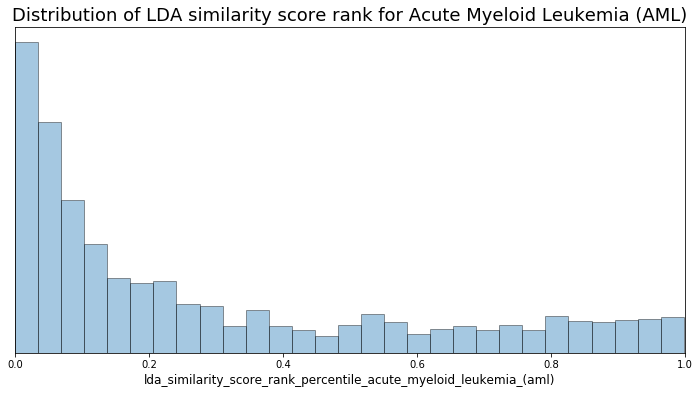

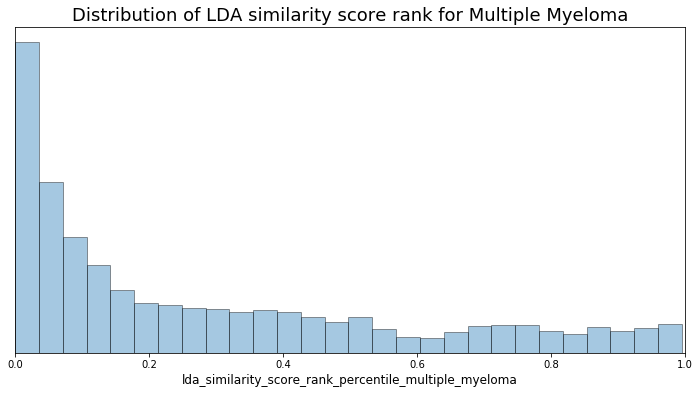

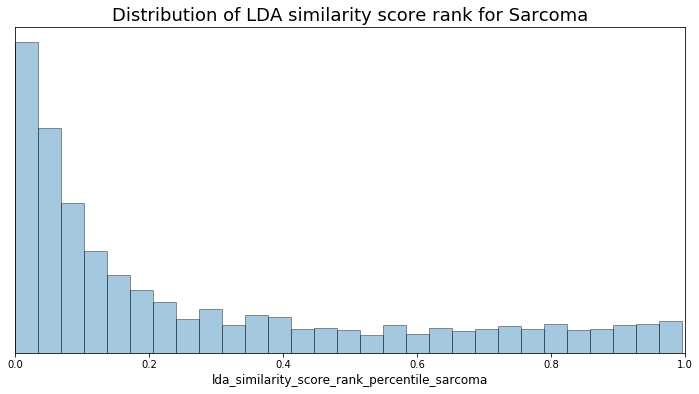

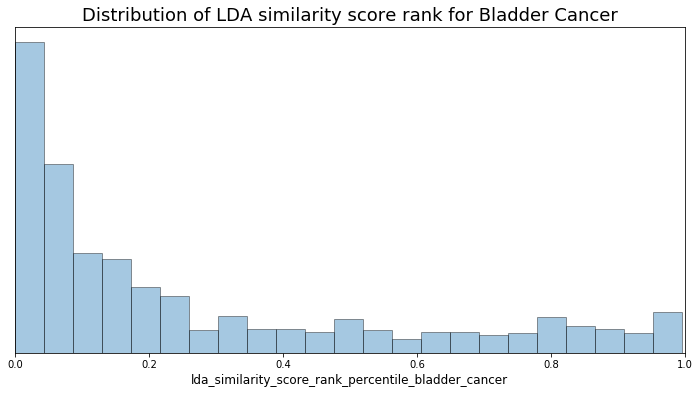

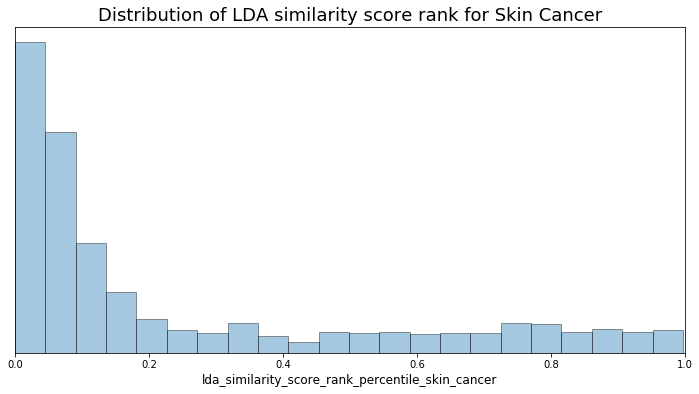

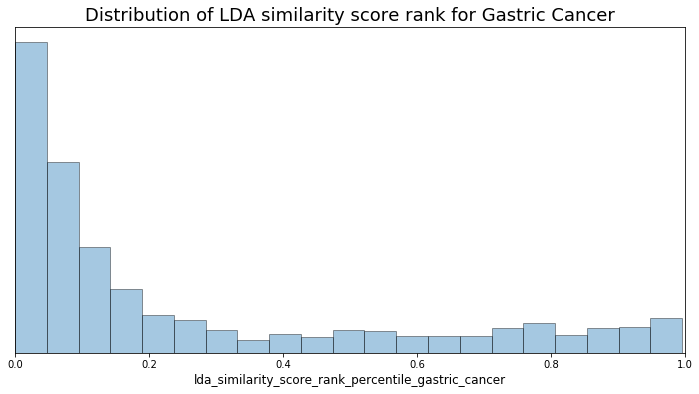

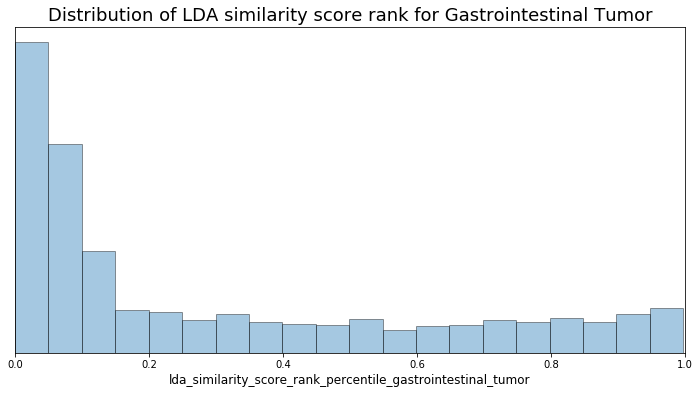

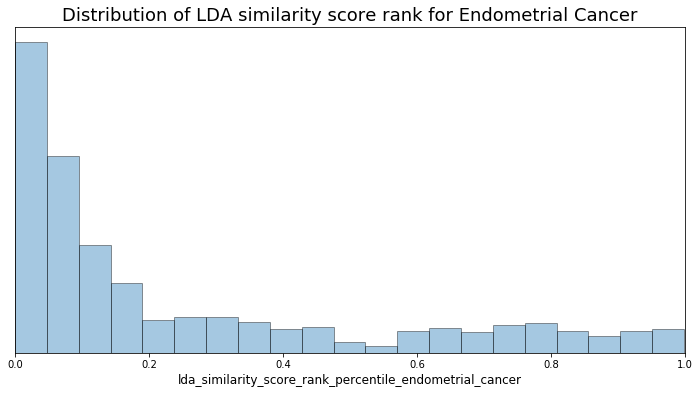

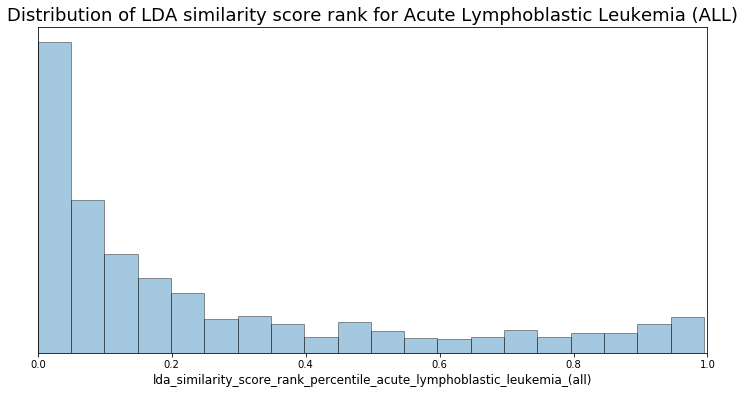

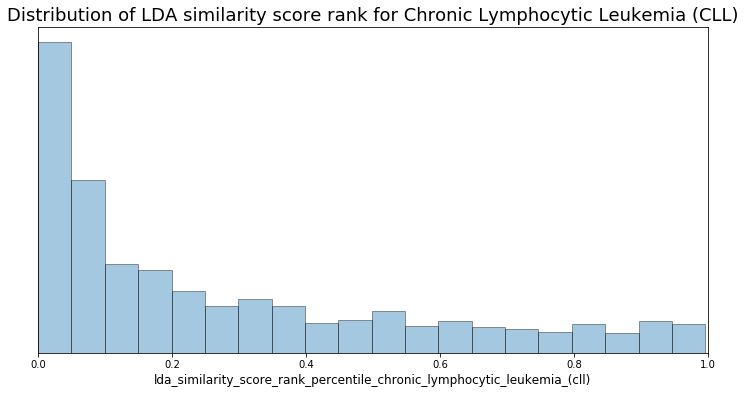

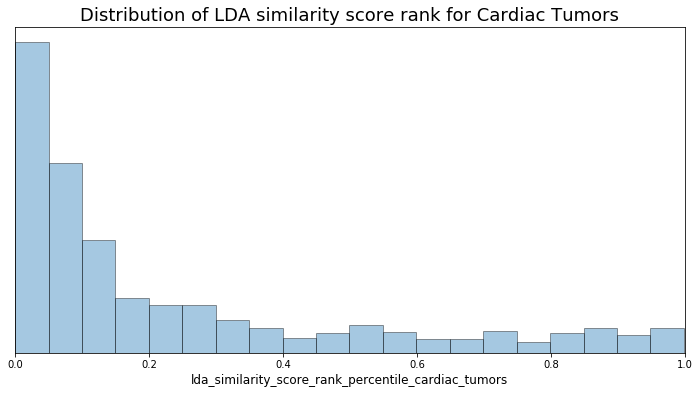

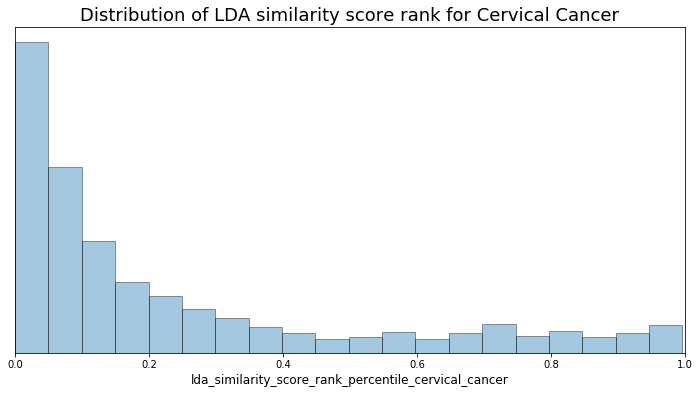

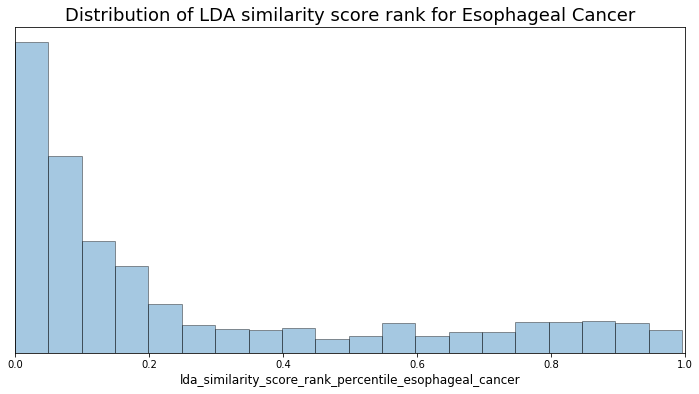

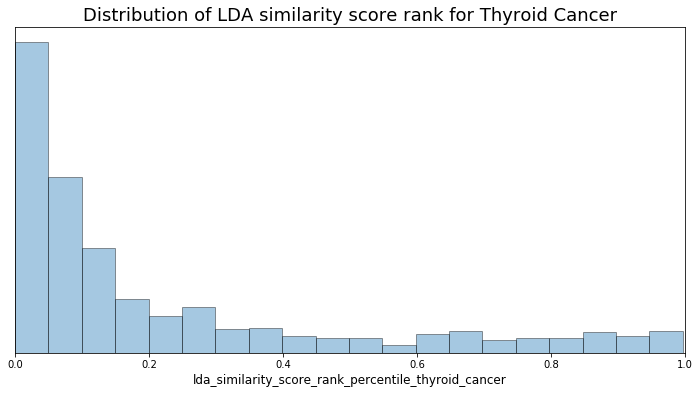

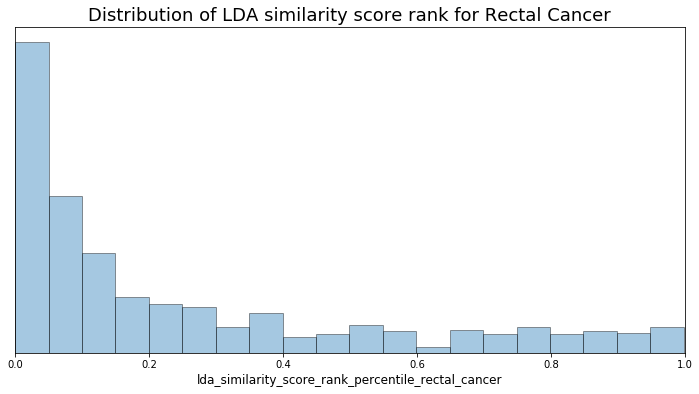

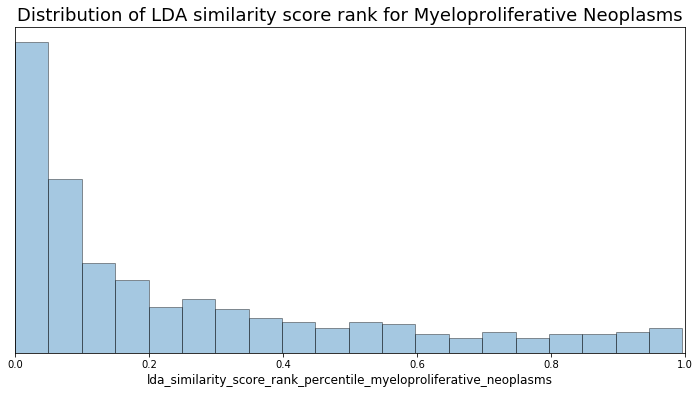

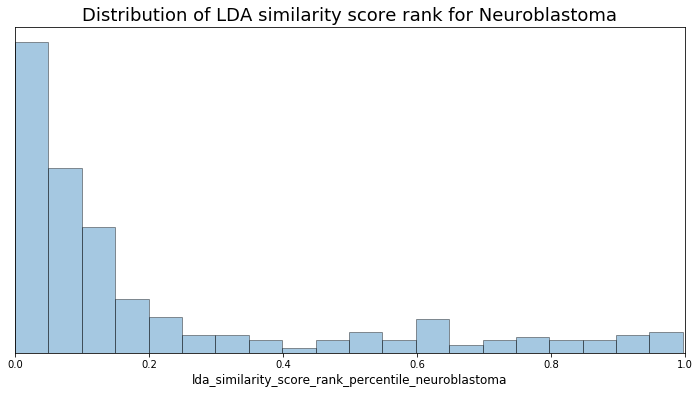

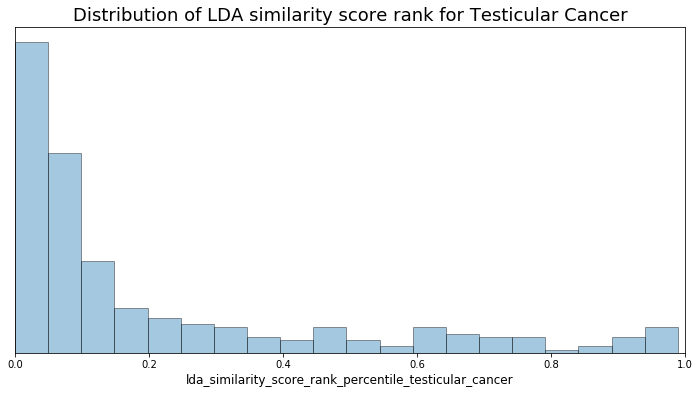

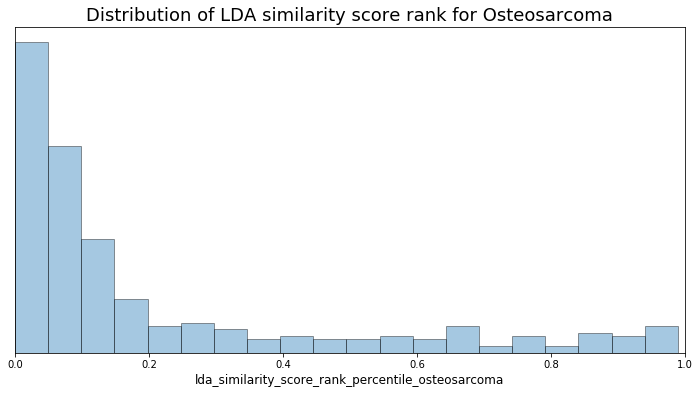

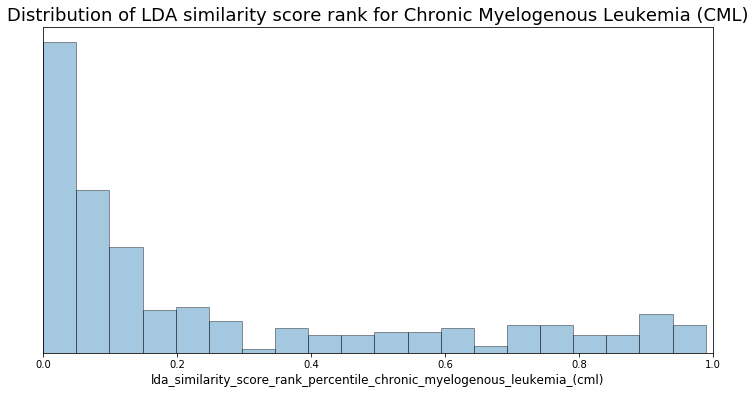

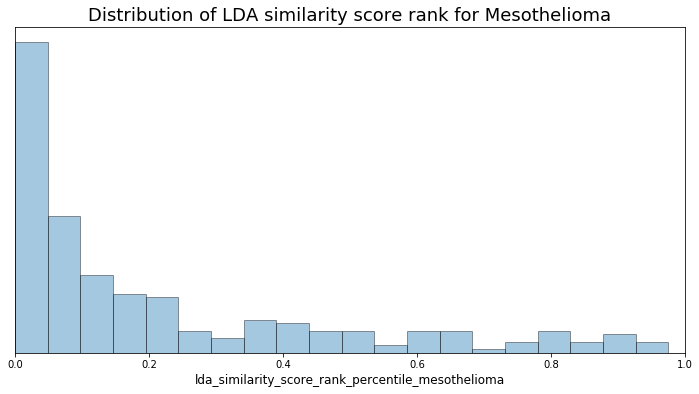

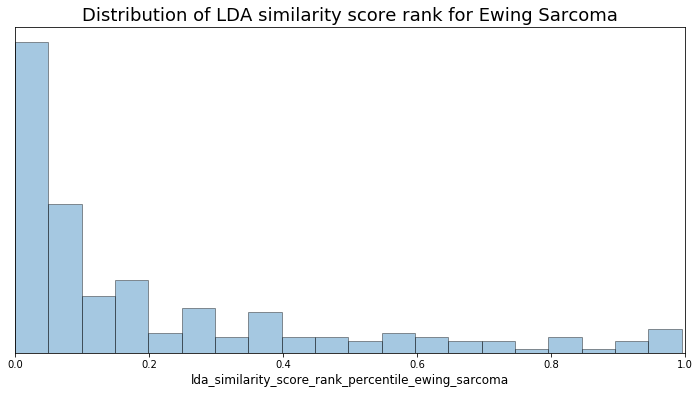

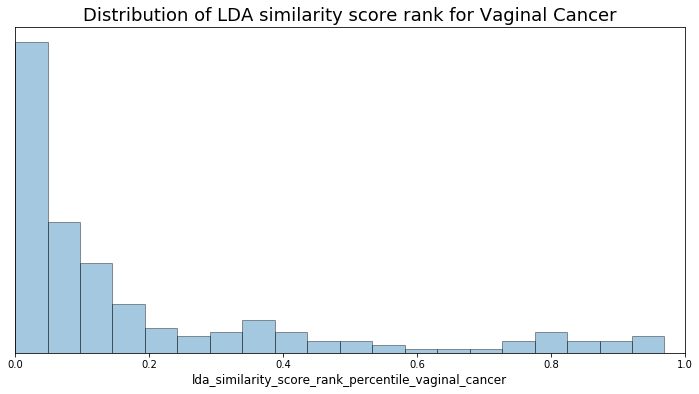

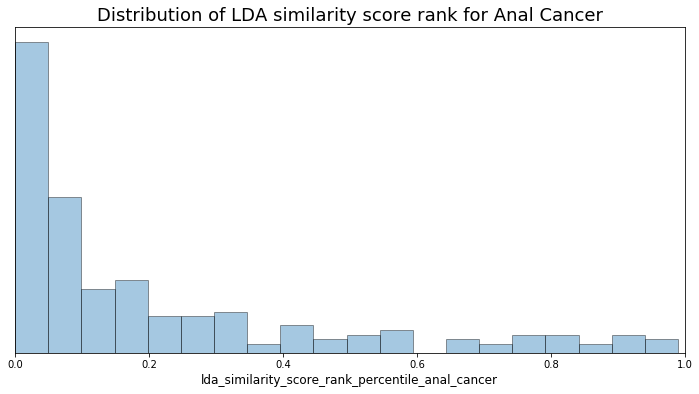

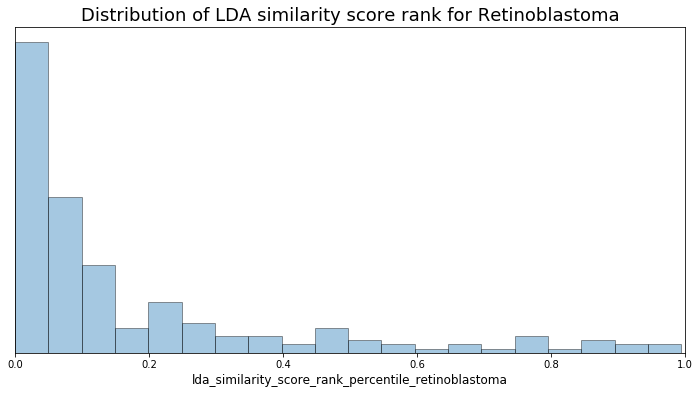

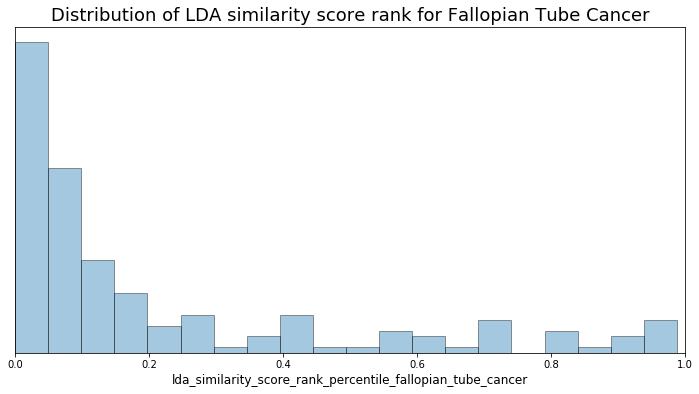

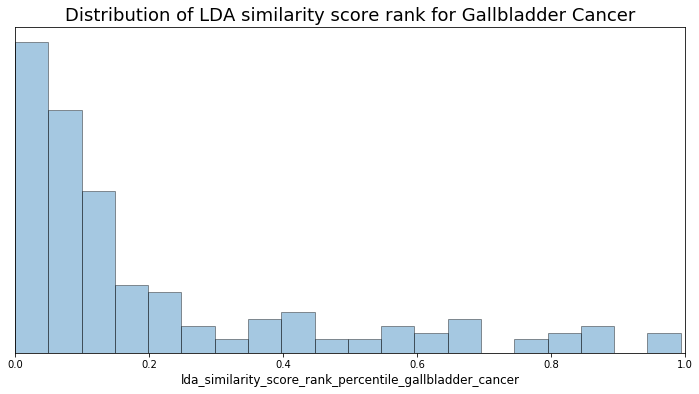

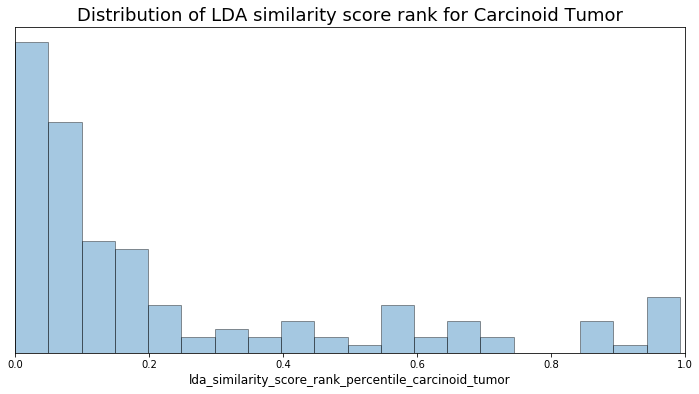

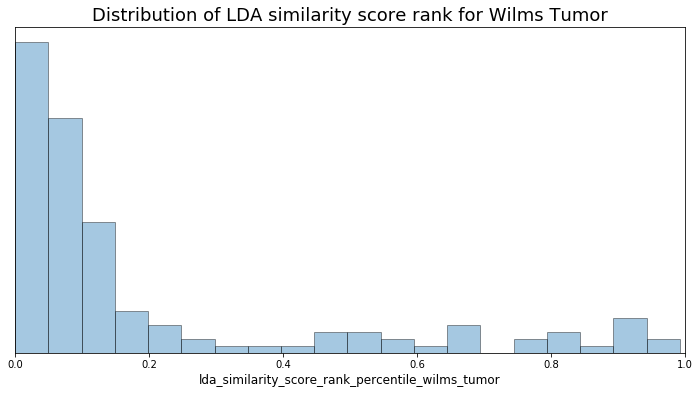

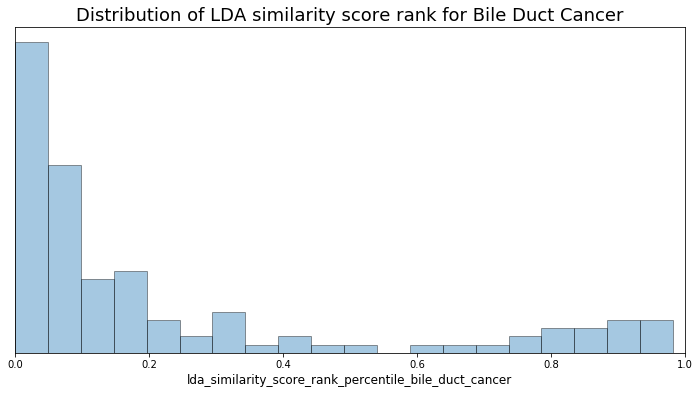

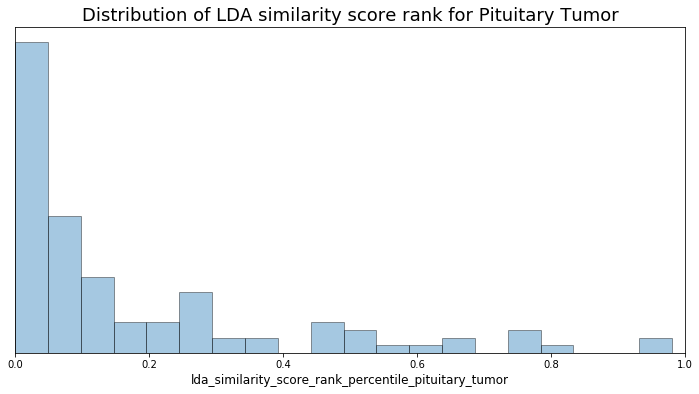

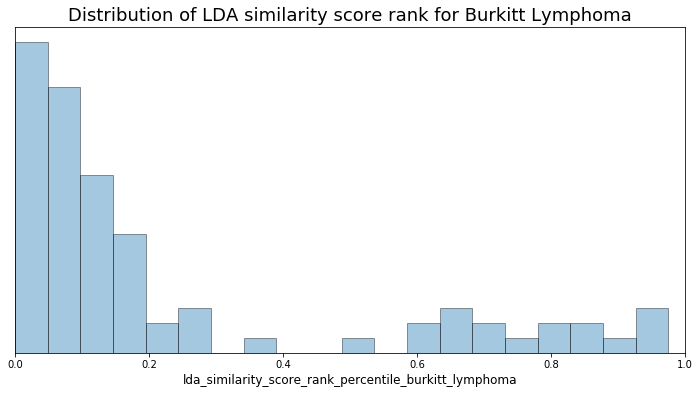

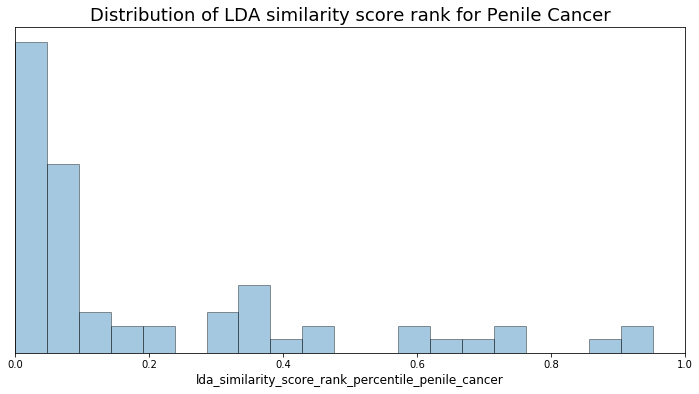

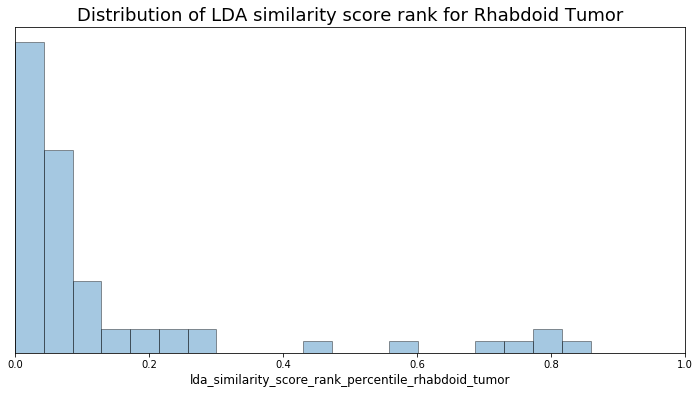

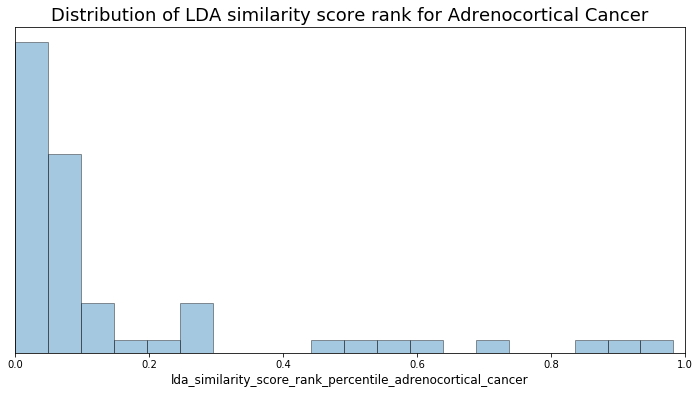

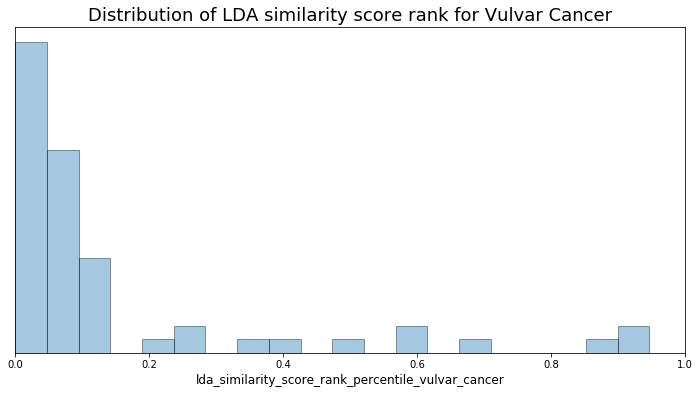

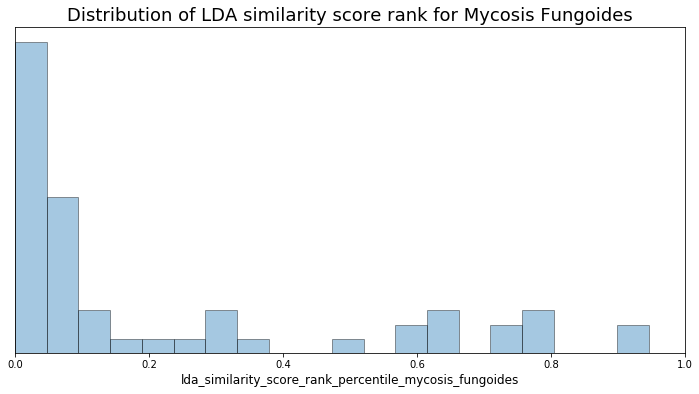

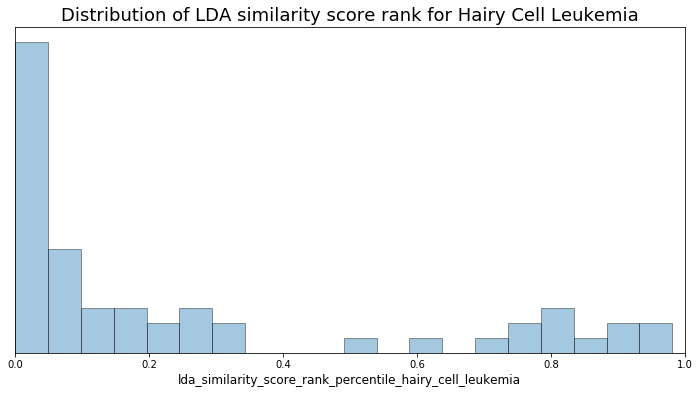

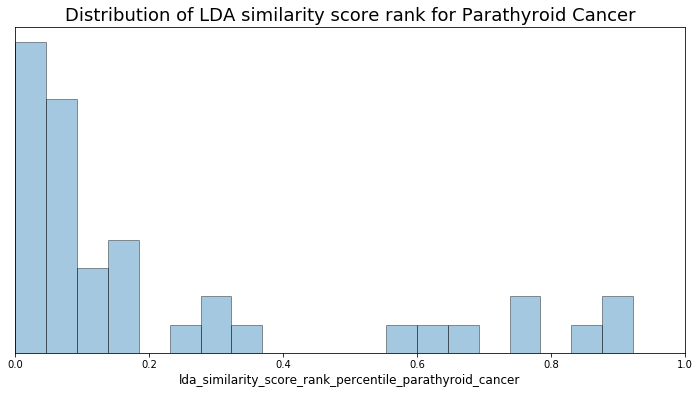

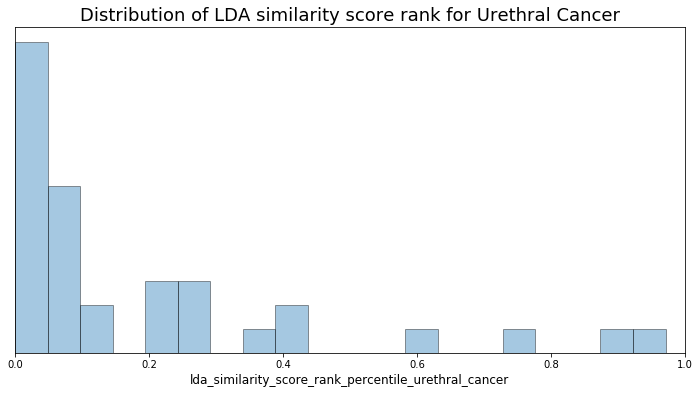

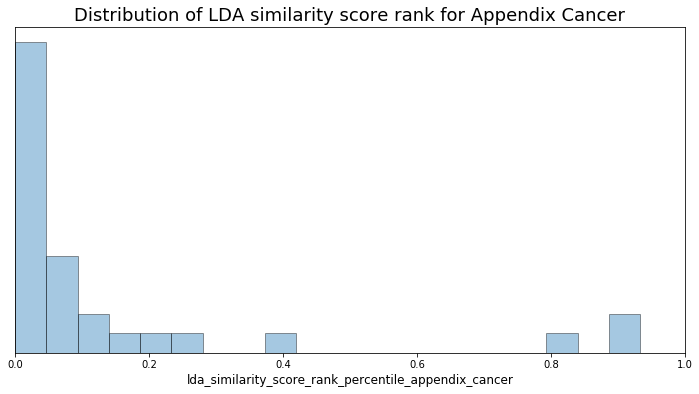

In [50]:
for cancer_type in cancer_types:
    plot_lda_similarity_rank(cancer_type)

In [66]:
top10_dict={}
top20_dict={}
top30_dict={}

In [67]:
def extract_lda_similarity_rank(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))
    top10_dict[cancer_type] = sum(subset_df['lda_similarity_rank_{}_percentile'.format(prefix)]<=0.1)/subset_df.shape[0]
    top20_dict[cancer_type] = sum(subset_df['lda_similarity_rank_{}_percentile'.format(prefix)]<=0.2)/subset_df.shape[0]
    top30_dict[cancer_type] = sum(subset_df['lda_similarity_rank_{}_percentile'.format(prefix)]<=0.3)/subset_df.shape[0]  

In [68]:
for cancer_type in cancer_types:
    extract_lda_similarity_rank(cancer_type)

In [69]:
df1 = pd.DataFrame.from_dict(top10_dict, orient='index', columns=['10th percentile'])
df2 = pd.DataFrame.from_dict(top20_dict, orient='index', columns=['20th percentile'])
df3 = pd.DataFrame.from_dict(top30_dict, orient='index', columns=['30th percentile'])

In [71]:
lda_rank_df=pd.concat([df1,df2,df3],axis=1,sort=False)
lda_rank_df

,10th percentile,20th percentile,30th percentile
Breast Cancer,0.419946,0.543268,0.601775
Lung Cancer,0.405401,0.537151,0.589888
Leukemia,0.352882,0.514107,0.617694
Prostate Cancer,0.404430,0.552016,0.617471
Colorectal Cancer,0.417613,0.578233,0.644143
Lymphoma,0.415251,0.550783,0.611056
Bone Cancer,0.459951,0.574327,0.633088
Melanoma,0.420496,0.583880,0.649891
Liver Cancer,0.445433,0.584752,0.640093
Kidney Cancer,0.418575,0.571058,0.644492


In [391]:
cancer_type = "Breast Cancer"
prefix="_".join(i.lower() for i in cancer_type.split())
subset_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))

In [51]:
subset_df.head()

,article_title,journal_title,journal_abbre,article_date,abstract,article_type,pub_days,citation,abstract_clean,Breast Cancer,...,Cervical Cancer,Esophageal Cancer,Thyroid Cancer,Rectal Cancer,text_clean_seq,text_length,abstract_processed,pmid,lda_similarity_rank_lung_cancer,lda_similarity_rank_lung_cancer_percentile
0,Compensation of BRG-1 function by Brm: insight...,The Journal of biological chemistry,J. Biol. Chem.,2001-11-21,The BRG-1 subunit of the SWI-SNF complex is in...,Journal Article,6635.0,82.0,The BRG-1 subunit of the SWI-SNF complex is in...,0,...,0,0,0,0,"[3, 21930, 14, 3350, 1, 3, 4983, 5071, 840, 16...",1568.0,"['brg', 'subunit', 'swi', 'snf', 'complex', 'i...",11719516,725,0.131388
1,"Role of the hepatocyte growth factor receptor,...",Cytokine & growth factor reviews,Cytokine Growth Factor Rev.,2002-02-01,Receptor tyrosine kinases have become importan...,Journal Article,6563.0,341.0,Receptor tyrosine kinases have become importan...,0,...,0,0,0,0,"[153, 564, 1549, 47, 1417, 305, 189, 637, 9, 3...",1505.0,"['receptor', 'tyrosine', 'kinase', 'important'...",11750879,4205,0.762051
2,Evaluation of the clinical relevance of the ex...,Leukemia research,Leuk. Res.,2002-02-01,The multidrug resistance (MDR) transporter-pro...,Journal Article,6563.0,35.0,The multidrug resistance MDR transporter-prote...,0,...,0,0,0,0,"[3, 4814, 251, 4186, 5246, 652, 19, 4455, 7131...",1668.0,"['multidrug', 'resistance', 'mdr', 'transporte...",11755464,257,0.046575
3,An orthotopic nude mouse model of oral tongue ...,Clinical cancer research : an official journal...,Clin. Cancer Res.,2002-01-01,"Despite advances in our understanding, prevent...",Journal Article,6594.0,119.0,Despite advances in our understanding preventi...,0,...,1,0,0,0,"[550, 954, 4, 114, 612, 1070, 2, 24, 1, 718, 2...",1826.0,"['despite', 'advance', 'understanding', 'preve...",11801572,199,0.036064
4,Chemoprevention of colorectal cancer.,The American journal of gastroenterology,Am. J. Gastroenterol.,2002-01-01,Colorectal cancer is the third most incident c...,Journal Article,6594.0,85.0,cancer is the third most incident cancer in th...,0,...,0,0,0,0,"[12, 16, 3, 1282, 96, 2631, 12, 4, 3, 1088, 90...",2101.0,"['colorectal', 'incident', 'united', 'state', ...",11808936,4733,0.857738


### Combined function LSA

### Running LSA using TF-IDF

In [41]:
lsa_model=gensim.models.LsiModel(bow_tfidf, num_topics=20, id2word=bow_dict)

In [42]:
## print all topics
for idx, topic in lsa_model.print_topics(-1):
    print('Topic: {}'.format(idx))
    print('Words: {}'.format(topic))
    print('')

Topic: 0
Words: 0.131*"patient" + 0.130*"survival" + 0.123*"response" + 0.118*"breast" + 0.118*"month" + 0.113*"chemotherapy" + 0.112*"mg" + 0.111*"year" + 0.107*"therapy" + 0.107*"dose"

Topic: 1
Words: 0.315*"mg" + 0.235*"dose" + -0.203*"breast" + 0.200*"day" + 0.157*"response" + 0.155*"toxicity" + -0.133*"risk" + 0.125*"week" + 0.124*"phase" + 0.123*"cycle"

Topic: 2
Words: 0.141*"egfr" + 0.139*"expression" + 0.131*"inhibitor" + 0.130*"pathway" + 0.127*"immune" + 0.123*"cd" + -0.121*"month" + -0.116*"rt" + 0.109*"kinase" + 0.108*"agent"

Topic: 3
Words: -0.387*"breast" + -0.339*"brca" + -0.236*"woman" + -0.184*"risk" + 0.168*"resection" + -0.165*"ci" + 0.132*"metastasis" + -0.123*"mg" + -0.116*"er" + -0.115*"survivor"

Topic: 4
Words: -0.250*"egfr" + 0.241*"aml" + 0.209*"survivor" + 0.179*"leukemia" + -0.176*"breast" + -0.140*"node" + 0.133*"lymphoma" + 0.121*"acute" + 0.120*"cll" + 0.119*"transplantation"

Topic: 5
Words: 0.275*"sup" + 0.224*"cd" + 0.173*"aml" + -0.159*"care" + 0.1

In [76]:
oncokb_df=pd.read_csv('data/cancerGeneList.tsv',sep='\t')

In [77]:
oncokb_df.head()

,Hugo Symbol,Entrez Gene ID,# of occurrence within resources (Column D-J),OncoKB Annotated,Is Oncogene,Is Tumor Suppressor Gene,MSK-IMPACT,MSK-HEME,FOUNDATION ONE,FOUNDATION ONE HEME,Vogelstein,SANGER CGC(05/30/2017)
0,LYL1,4066,2,No,No,No,No,No,No,Yes,No,Yes
1,LYN,4067,4,Yes,Yes,No,Yes,Yes,Yes,No,No,No
2,SH2D1A,4068,3,Yes,No,Yes,Yes,Yes,No,No,No,No
3,OLIG2,10215,1,No,No,No,No,No,No,No,No,Yes
4,EPCAM,4072,3,Yes,No,Yes,Yes,Yes,No,No,No,No


In [78]:
WordNetLemmatizer().lemmatize('BCR-ABL1').lower()

'bcr-abl1'

In [9]:
lda_data=pd.read_csv(os.path.join(base_dir, 'models_lda/lda_summary.csv'))

In [10]:
lda_data.head()

,cancer_type,pmid_num,bow_dict_len,pred1_match,pred2_match,pred3_match,top1_match,top3_match
0,Breast Cancer,8563,13055,3869,1561,959,0.451828,0.746117
1,Lung Cancer,5518,10725,2433,915,644,0.440921,0.723451
2,Leukemia,4962,9485,2481,1006,566,0.500000,0.816808
3,Prostate Cancer,4018,9376,1843,692,491,0.458686,0.753111
4,Colorectal Cancer,3611,8737,1747,568,395,0.483800,0.750485


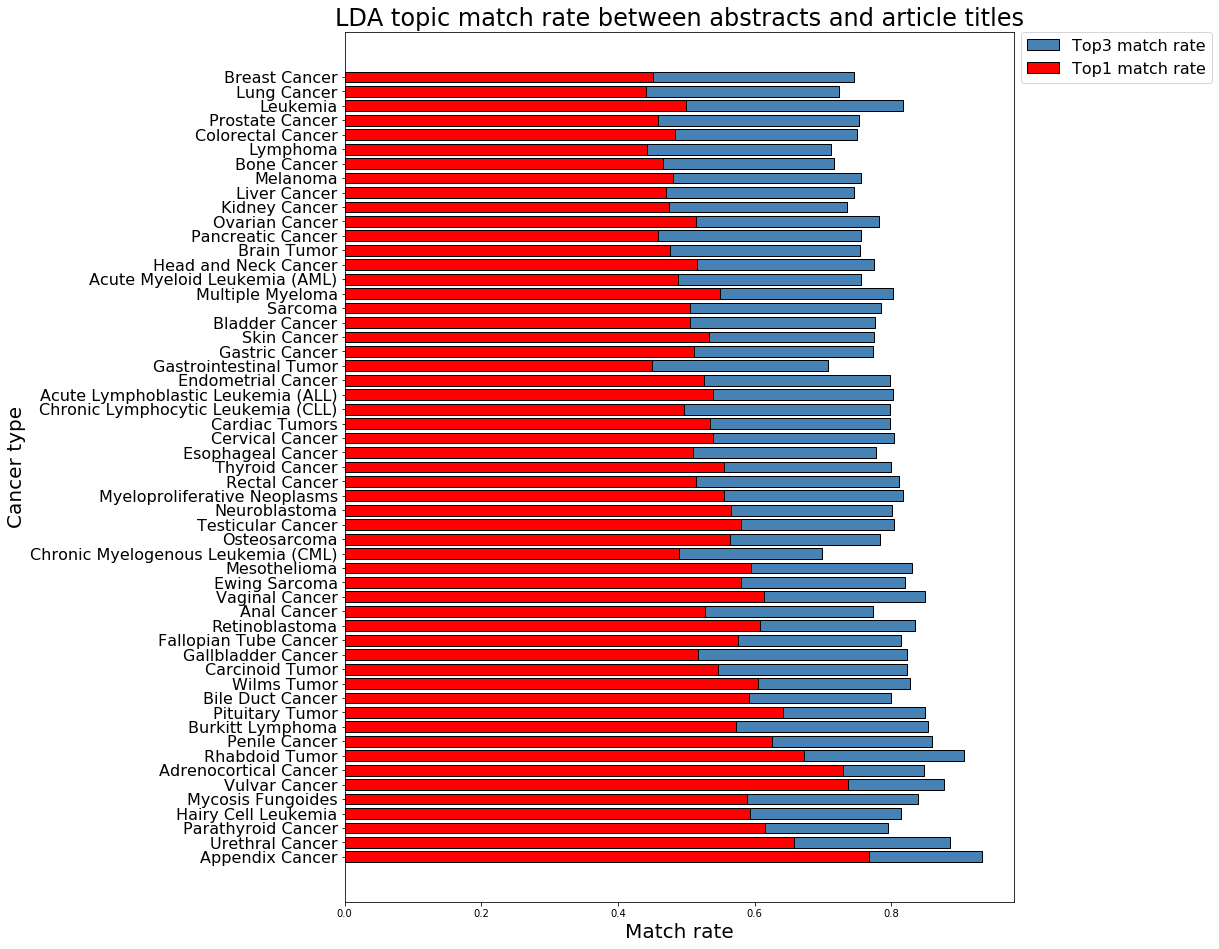

In [16]:
fig = plt.figure(figsize = (12,16))
ax = fig.add_subplot(1,1,1)
width = 0.75 # the width of the bars 
ind = np.arange(len(lda_data))  # the x locations for the groups
ax.barh(ind, lda_data.top3_match, width, edgecolor='black',color='steelblue',label='Top3 match rate')
ax.barh(ind, lda_data.top1_match, width, edgecolor='black',color='red',label='Top1 match rate')
ax.invert_yaxis()
plt.yticks(ind, labels = lda_data.cancer_type, fontsize=12)
plt.yticks(fontsize=16)
#plt.ylim(0,110)
plt.ylabel('Cancer type', fontsize=20)
plt.xlabel('Match rate', fontsize=20)
plt.title('LDA topic match rate between abstracts and article titles', fontsize=24)
plt.legend(fontsize=16,bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

### Compare LDA and W2V models

In [21]:
cancer_type = "Breast Cancer"
prefix="_".join(i.lower() for i in cancer_type.split())
subset_w2v_df = pd.read_csv(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.csv'.format(prefix)))
subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)] = subset_w2v_df['w2v_similarity_rank_{}'.format(prefix)]/subset_w2v_df.shape[0]
subset_lda_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))
subset_bert_df = pd.read_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)))
subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)] = subset_bert_df['bert_similarity_rank_{}'.format(prefix)]/subset_bert_df.shape[0]

Text(0, 0.5, 'Density')

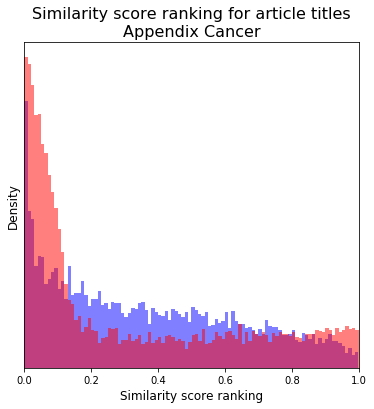

In [25]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','red']
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],color=palette[0],kde=False,hist=True,ax=ax,label='Word2Vec',bins=100,hist_kws={"alpha":0.5})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],color=palette[1],kde=False,hist=True,ax=ax,label='LDA',bins=100,hist_kws={"alpha":0.5})    
ax.set_xlim(0,1)
ax.set_title('Similarity score ranking for article titles\n{}'.format(cancer_type),fontsize=16)
ax.set_xlabel('Similarity score ranking', fontsize=12)
ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

In [7]:
abstract_df=pd.read_csv(os.path.join(base_dir,'data/abstract_citation_annot_w2vRank_df_50930.csv'),index_col='pmid')
abstract_df['similarity_rank_percentile'] = abstract_df.similarity_rank/abstract_df.shape[0]

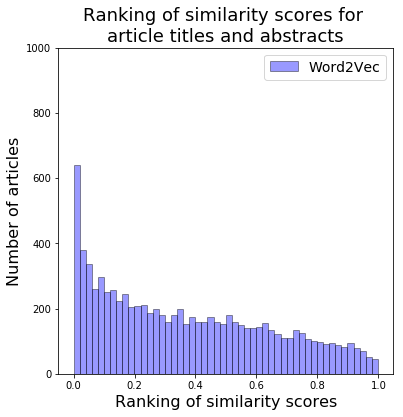

In [142]:
from scipy.stats import norm
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['#99bbff','#ff9900','#ff9999','#cc99ff','#59b300']
#palette=['blue','orange','red','grey']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],bins=50, kde=False,hist=True,ax=ax,label='Word2Vec', hist_kws={"histtype": "bar", "color":'blue','edgecolor':'black'})
#sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],color=palette[1],kde=False,hist=True,ax=ax,label='LDA',bins=500, hist_kws={"histtype": "bar", "linewidth": 3,"color":palette[1]})  
#sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)], color=palette[2],kde=False,hist=True,ax=ax,label='BioBERT',bins=500, hist_kws={"histtype": "bar", "linewidth": 3,"color":palette[2]})
#ax.set_xlim(0,1)
ax.set_title('Ranking of similarity scores for \narticle titles and abstracts',fontsize=18)
ax.set_xlabel('Ranking of similarity scores', fontsize=16)
ax.set_ylim(0,1000)
#ax.set_yticks([])
ax.set_ylabel('Number of articles',fontsize=16)
plt.legend(fontsize=14)

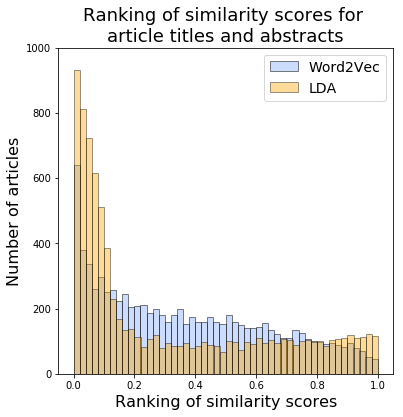

In [143]:
from scipy.stats import norm
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','orange','red','grey']
palette=['#99bbff','#ff9900','#ff9999','#cc99ff','#59b300']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,ax=ax,label='Word2Vec',bins=50, hist_kws={"histtype": "bar", "color":palette[0],'alpha':0.5,'edgecolor':'black'})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,ax=ax,label='LDA',bins=50, hist_kws={"histtype": "bar", "color":'orange','edgecolor':'black'})  
#sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)], color=palette[2],kde=False,hist=True,ax=ax,label='BioBERT',bins=500, hist_kws={"histtype": "bar", "linewidth": 3,"color":palette[2]})
#ax.set_xlim(0,1)
ax.set_title('Ranking of similarity scores for \narticle titles and abstracts',fontsize=18)
ax.set_xlabel('Ranking of similarity scores', fontsize=16)
ax.set_ylim(0,1000)
#ax.set_yticks([])
ax.set_ylabel('Number of articles',fontsize=16)
plt.legend(fontsize=14)

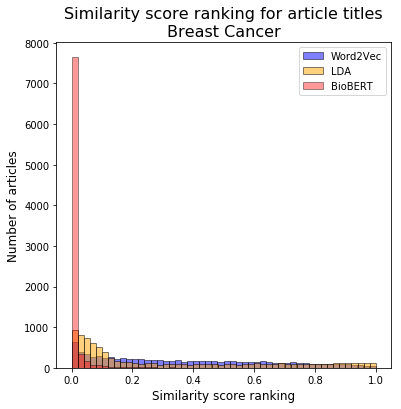

In [128]:
from scipy.stats import norm
fig,ax=plt.subplots(figsize=(6,6))
palette=['blue','orange','red','grey']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='Word2Vec',bins=50, ax=ax,hist_kws={"histtype": "bar", "color":palette[0],'alpha':0.5,'edgecolor':'black'})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='LDA',bins=50, ax=ax,hist_kws={"histtype": "bar", "color":palette[1],'alpha':0.5,'edgecolor':'black'})  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='BioBERT',bins=50, ax=ax,hist_kws={"histtype": "bar", "color":'red','edgecolor':'black'})
#ax.set_xlim(0,1)
ax.set_title('Ranking of similarity scores for \narticle titles and abstracts',fontsize=16)
ax.set_xlabel('Ranking of similarity scores', fontsize=12)
#ax.set_ylim(0,3000)
#ax.set_yticks([])
ax.set_ylabel('Number of articles',fontsize=12)
plt.legend(fontsize=14)

In [121]:
sns.color_palette("RdBu_r", 7)[-1]

(0.7284890426758939, 0.15501730103806227, 0.1973856209150327)

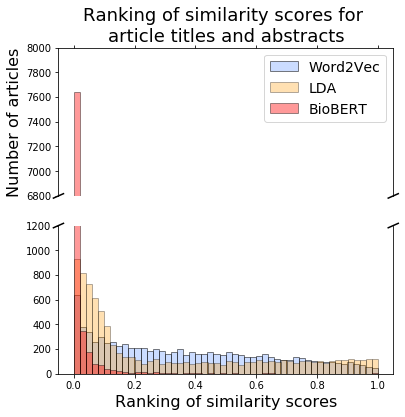

In [145]:
from scipy.stats import norm
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,figsize=(6,6))
#palette=['blue','orange','red','grey']
palette=['#99bbff','#ff9900','#ff9999','#cc99ff','#59b300']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='Word2Vec',bins=50, ax=ax1,hist_kws={"histtype": "bar", "color":palette[0],'alpha':0.5,'edgecolor':'black'})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='LDA',bins=50, ax=ax1,hist_kws={"histtype": "bar", "color":palette[1],'alpha':0.3,'edgecolor':'black'})  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='BioBERT',bins=50, ax=ax1,hist_kws={"histtype": "bar", "color":'red','edgecolor':'black'})
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='Word2Vec',bins=50, ax=ax2,hist_kws={"histtype": "bar", "color":palette[0],'alpha':0.5,'edgecolor':'black'})
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='LDA',bins=50, ax=ax2,hist_kws={"histtype": "bar", "color":palette[1],'alpha':0.3,'edgecolor':'black'})  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)],kde=False,hist=True,label='BioBERT',bins=50, ax=ax2,hist_kws={"histtype": "bar", "color":'red','edgecolor':'black'})

#ax.set_xlim(0,1)
ax1.set_title('Ranking of similarity scores for \narticle titles and abstracts',fontsize=18)
ax1.set_xlabel("")
ax2.set_xlabel('Ranking of similarity scores', fontsize=16)
ax2.set_ylim(0,1200)
ax1.set_ylim(6800,8000)
ax1.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()
#ax.set_yticks([])
ax1.set_ylabel('Number of articles',fontsize=16)

d = .015
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

ax1.legend(fontsize=14)

Text(0, 0.5, 'Density')

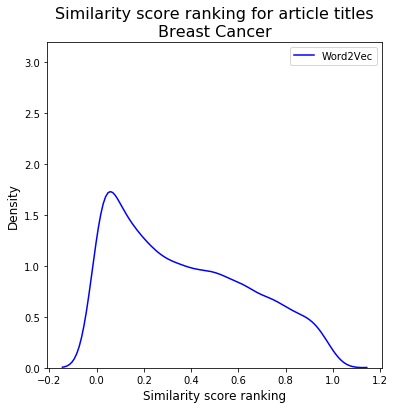

In [37]:
from scipy.stats import norm
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','orange','red','grey']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],color=palette[0],kde=True,hist=False,ax=ax,label='Word2Vec')
#sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],color=palette[1],kde=True,hist=False,ax=ax,label='LDA')  
#sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)], color=palette[2],kde=True,hist=False,ax=ax,label='BioBERT')
#ax.set_xlim(0,1)
ax.set_title('Similarity score ranking for article titles\n{}'.format(cancer_type),fontsize=16)
ax.set_xlabel('Similarity score ranking', fontsize=12)
ax.set_ylim(0,3.2)
#ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

Text(0, 0.5, 'Density')

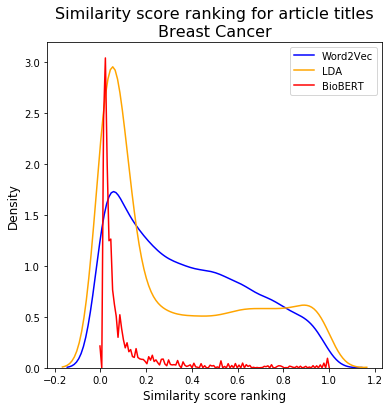

In [71]:
from scipy.stats import norm
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','orange','red','grey']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],color=palette[0],kde=True,hist=False,ax=ax,label='Word2Vec')
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],color=palette[1],kde=True,hist=False,ax=ax,label='LDA')  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)], color=palette[2],kde=True,hist=False,ax=ax,label='BioBERT')
#ax.set_xlim(0,1)
ax.set_title('Similarity score ranking for article titles\n{}'.format(cancer_type),fontsize=16)
ax.set_xlabel('Similarity score ranking', fontsize=12)
ax.set_ylim(0,3.2)
#ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

In [29]:
subset_bert_df.shape

(8563, 12)

Text(0, 0.5, 'Density')

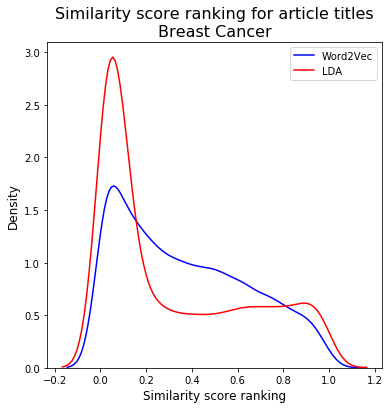

In [25]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
palette=['blue','red','orange','grey']
#sns.distplot(abstract_df['similarity_rank_percentile'],color=palette[2],kde=True,hist=False,ax=ax,label='Word2Vec_PanCancer')
sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],color=palette[0],kde=True,hist=False,ax=ax,label='Word2Vec')
sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],color=palette[1],kde=True,hist=False,ax=ax,label='LDA')  
sns.distplot(subset_bert_df['bert_similarity_rank_{}_percentile'.format(prefix)], color=palette[2],kde=True,hist=False,ax=ax,label='BioBERT')
#ax.set_xlim(0,1)
ax.set_title('Similarity score ranking for article titles\n{}'.format(cancer_type),fontsize=16)
ax.set_xlabel('Similarity score ranking', fontsize=12)
#ax.set_yticks([])
ax.set_ylabel('Density',fontsize=12)

In [26]:
def plot_lda_w2v_similarity_rank(cancer_type):
    prefix="_".join(i.lower() for i in cancer_type.split())
    subset_w2v_df = pd.read_csv(os.path.join(base_dir, 'models_w2v/{}_w2v_similarity_score.csv'.format(prefix)))
    subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)] = subset_w2v_df['w2v_similarity_rank_{}'.format(prefix)]/subset_w2v_df.shape[0]
    subset_lda_df = pd.read_csv(os.path.join(base_dir, 'models_lda/{}_lda_similarity_score.csv'.format(prefix)))
    subset_bert_df = pd.read_csv(os.path.join(base_dir, 'bert_data/{}_bert_maxlen128_similarity_score.csv'.format(prefix)))
    fig,ax=plt.subplots(1,1,figsize=(6,6))
    palette=['blue','red']
    sns.distplot(subset_w2v_df['w2v_similarity_rank_{}_percentile'.format(prefix)],color=palette[0],hist=False,ax=ax,label='Word2Vec')
    sns.distplot(subset_lda_df['lda_similarity_rank_{}_percentile'.format(prefix)],color=palette[1],hist=False,ax=ax,label='LDA')    
    #ax.set_xlim(0,1)
    ax.set_title('Similarity score ranking for article titles\n{}'.format(cancer_type),fontsize=16)
    ax.set_xlabel('Similarity score ranking', fontsize=12)
    ax.set_yticks([])
    ax.set_ylabel('Density',fontsize=12)

    plt.show()
    fig.savefig(os.path.join(base_dir, 'models_lda/{}_lda_w2v_similarity_score.png'.format(prefix)))

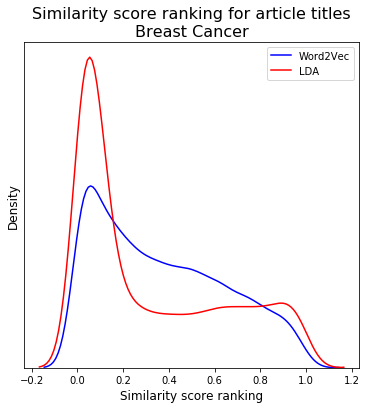

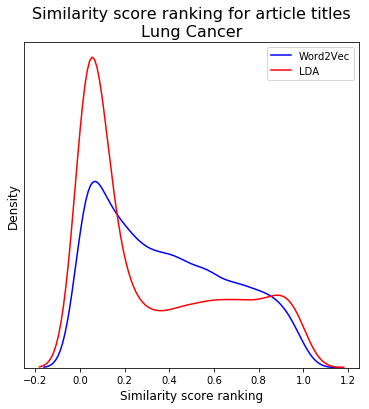

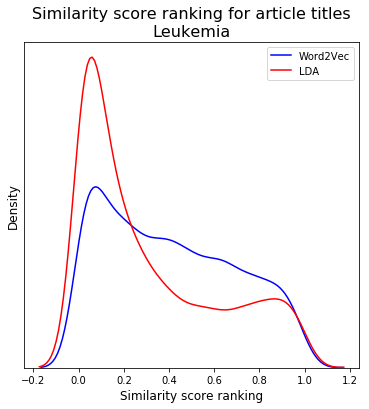

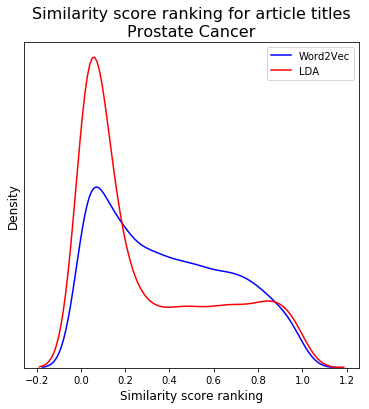

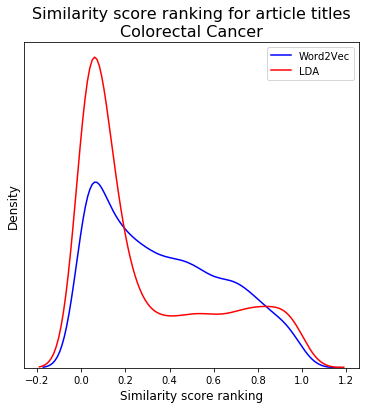

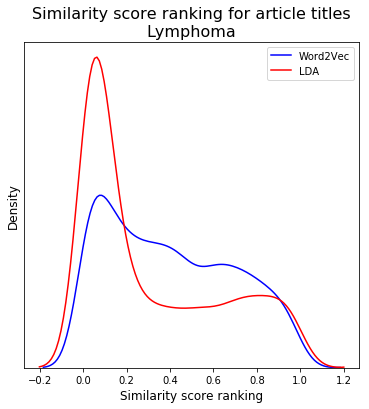

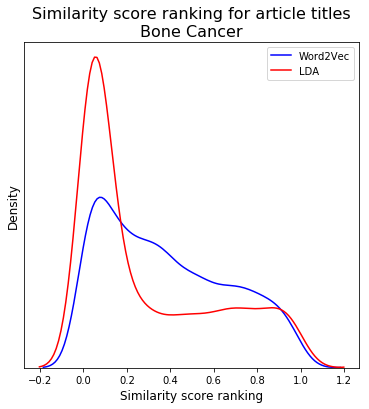

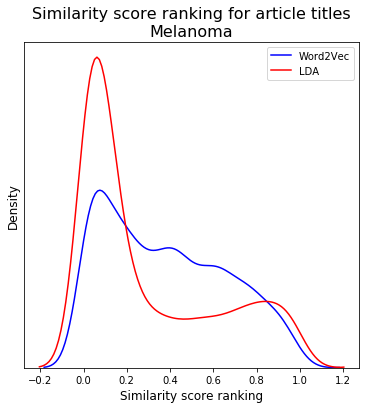

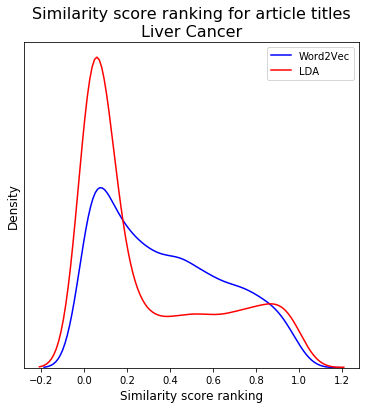

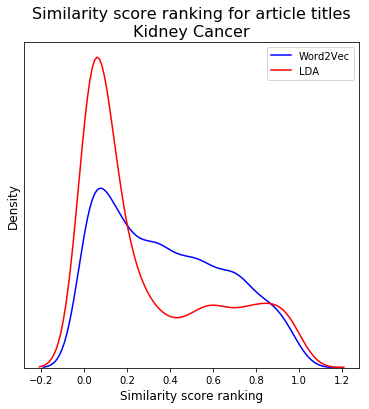

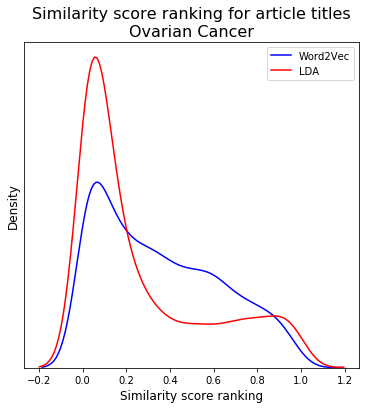

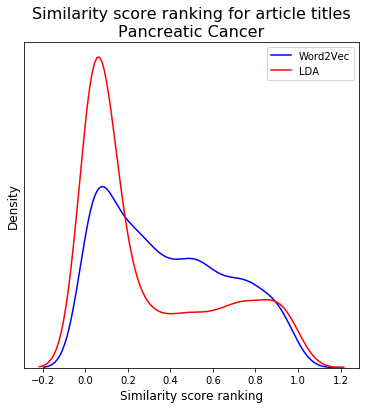

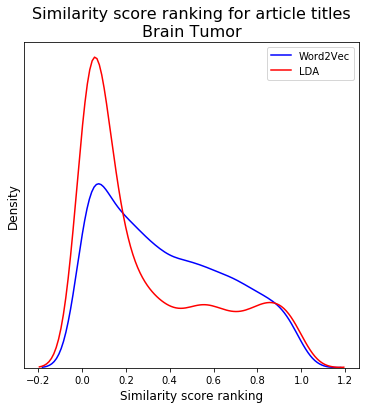

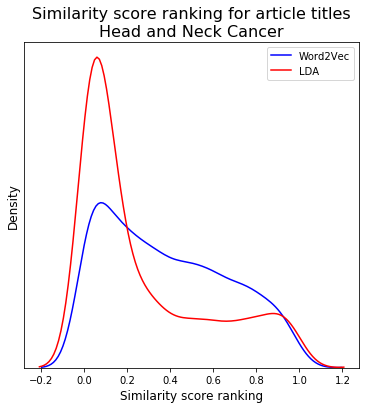

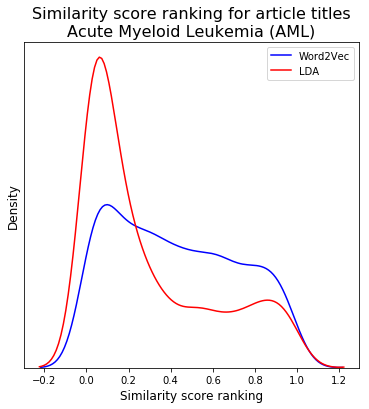

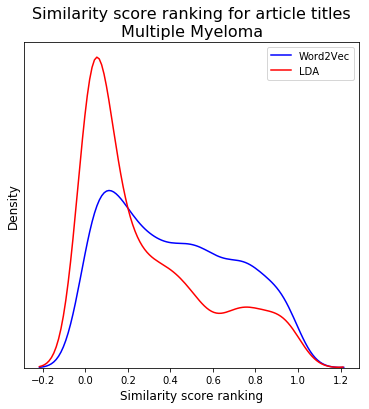

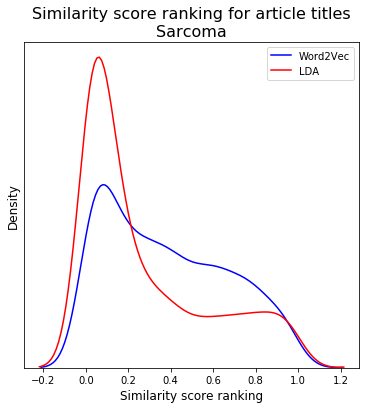

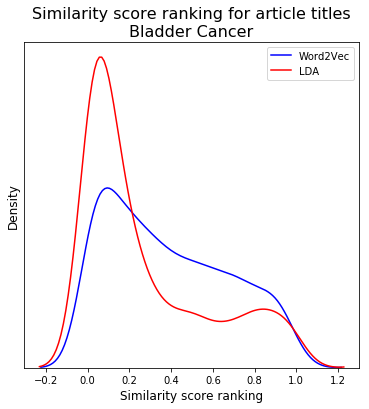

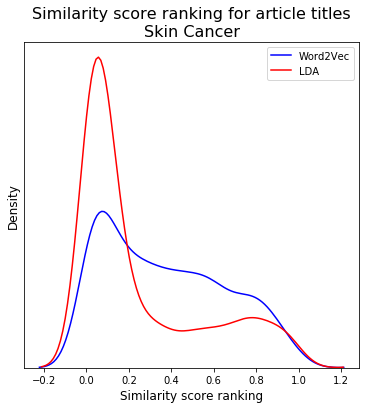

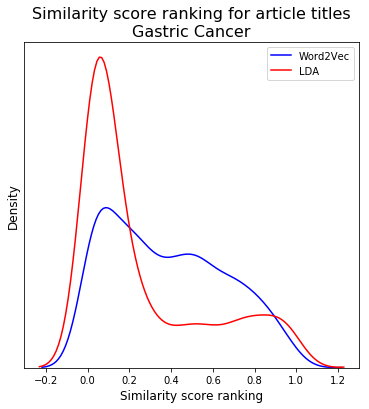

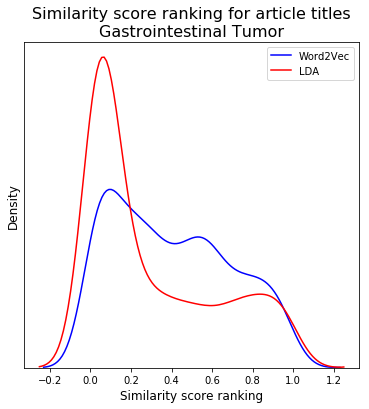

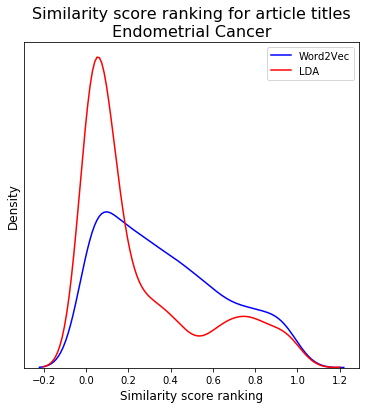

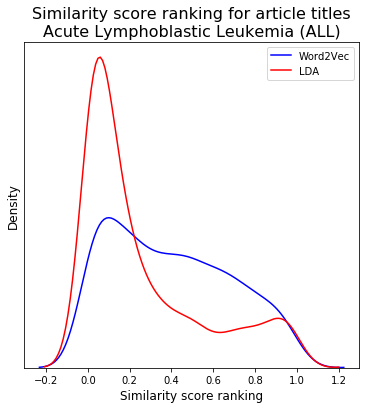

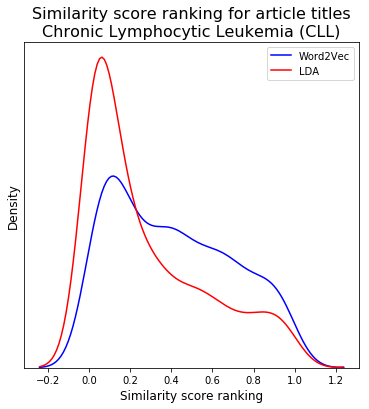

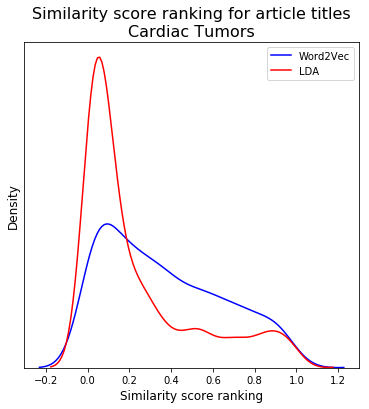

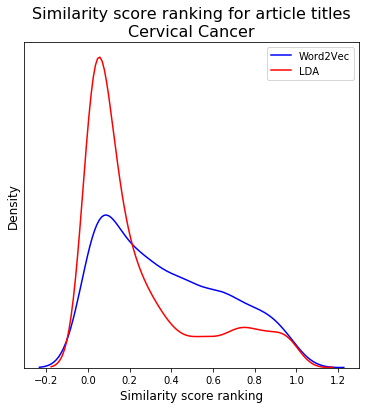

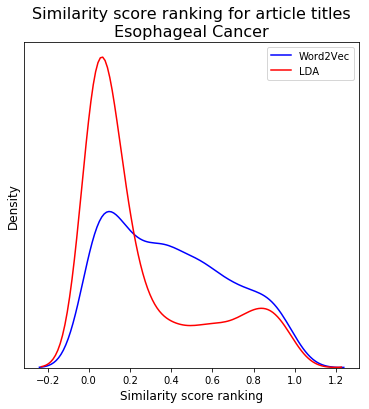

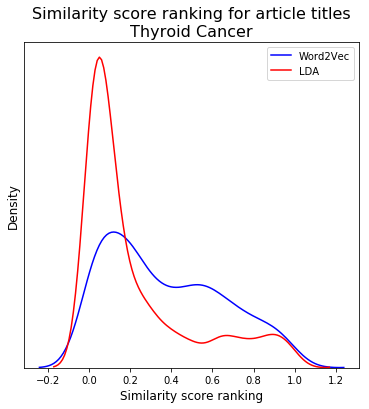

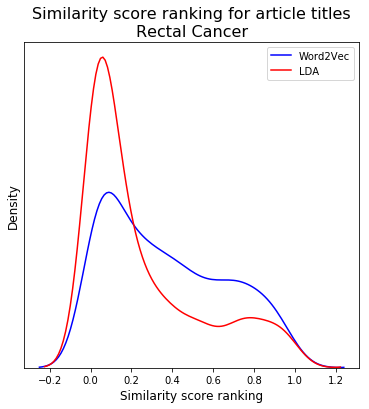

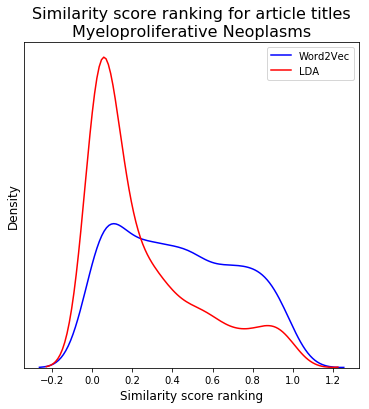

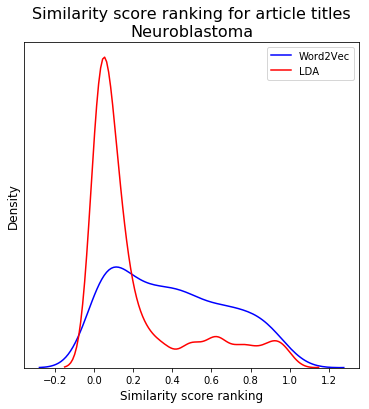

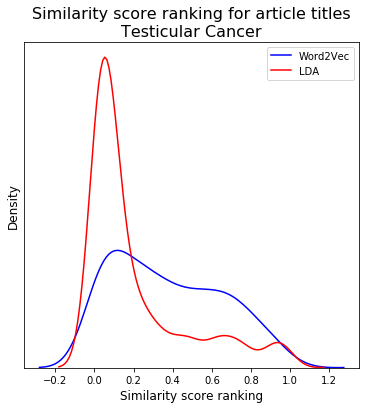

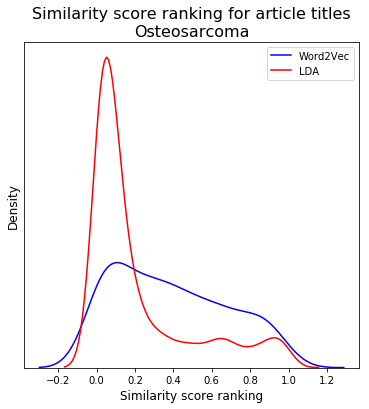

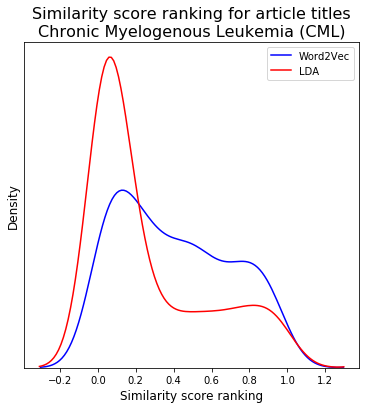

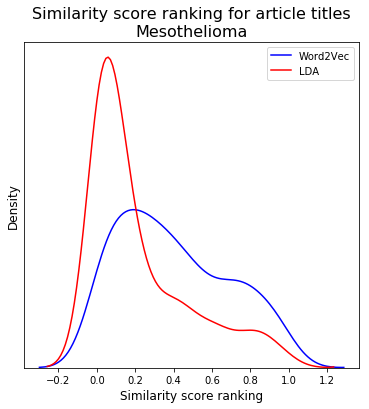

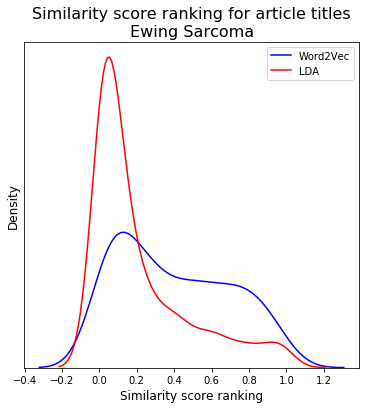

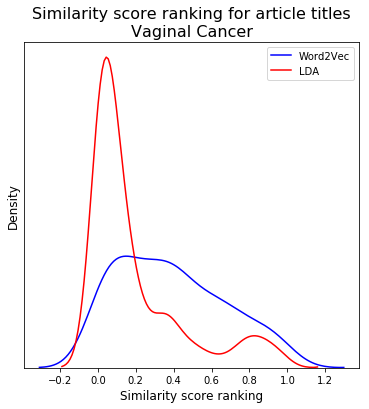

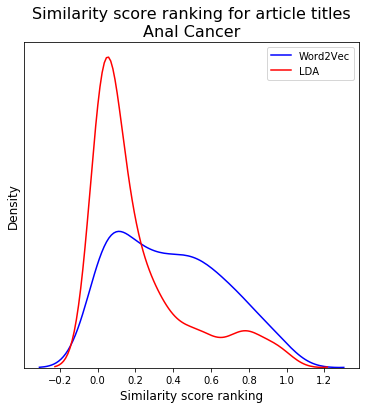

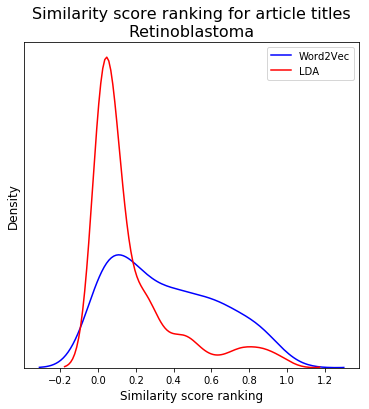

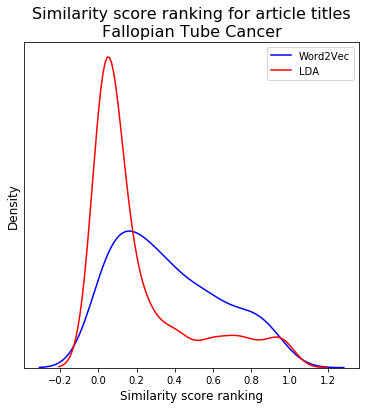

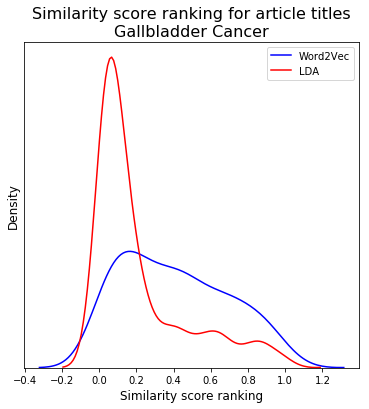

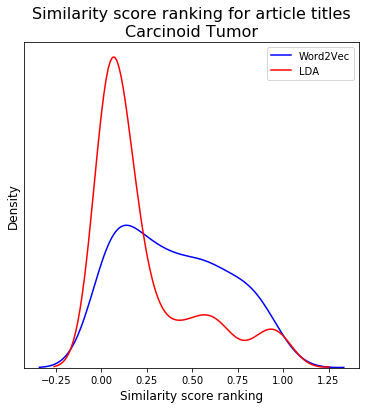

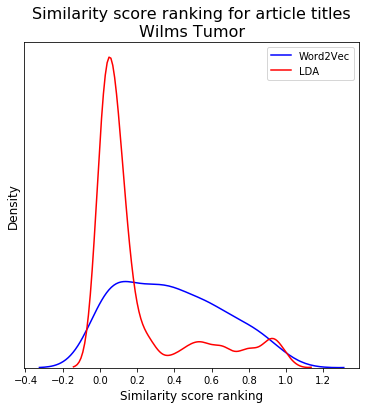

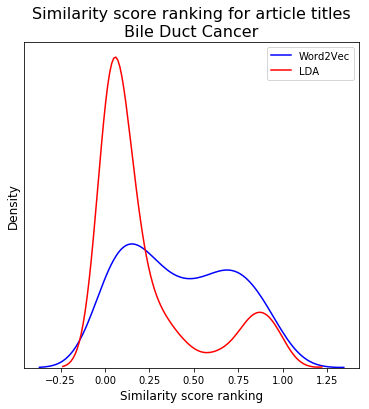

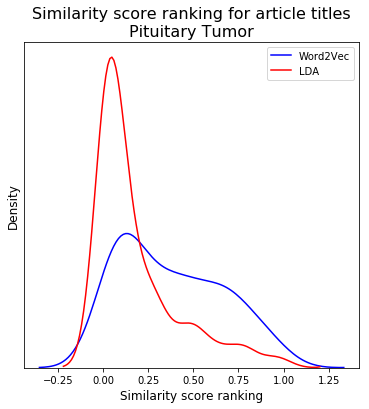

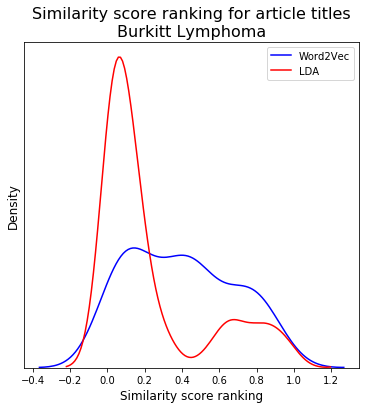

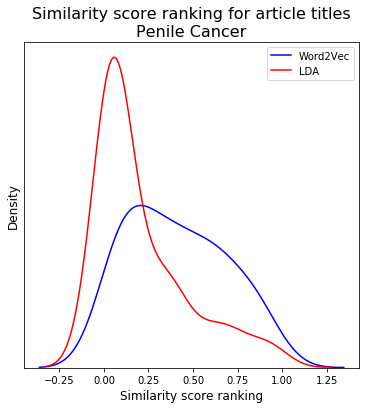

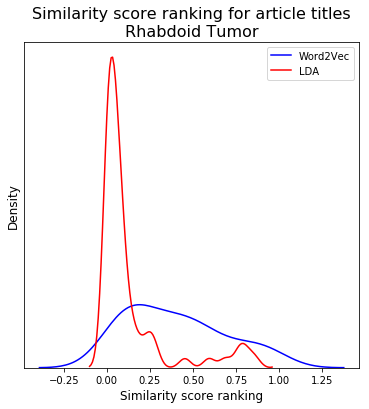

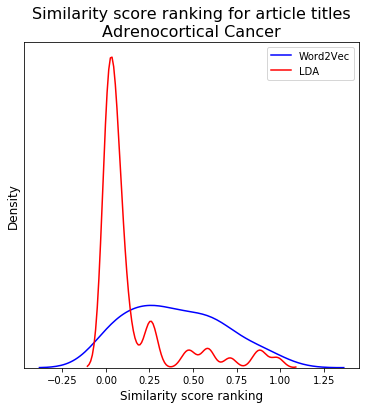

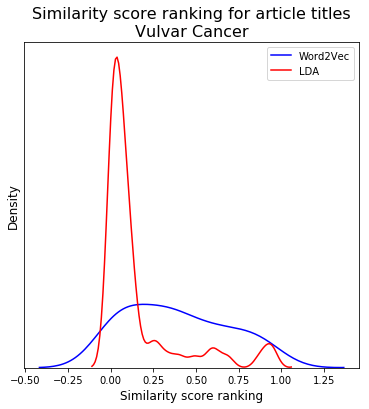

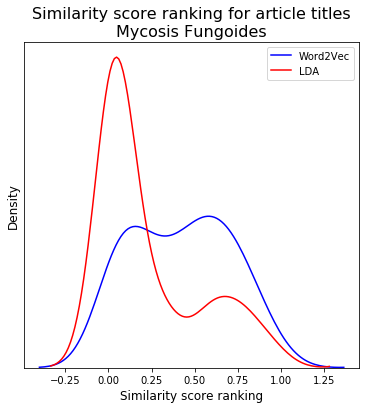

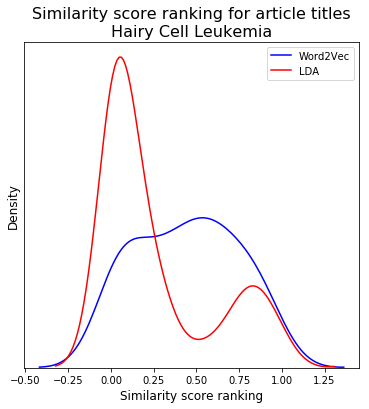

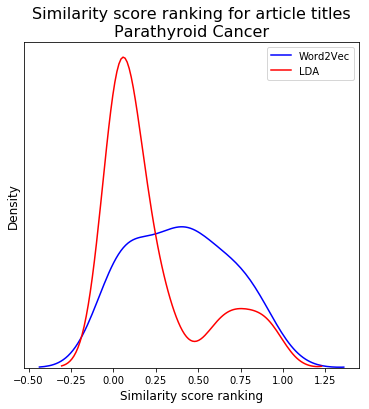

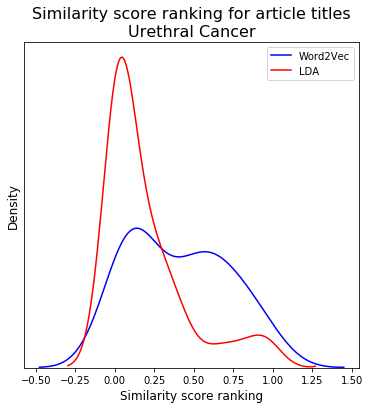

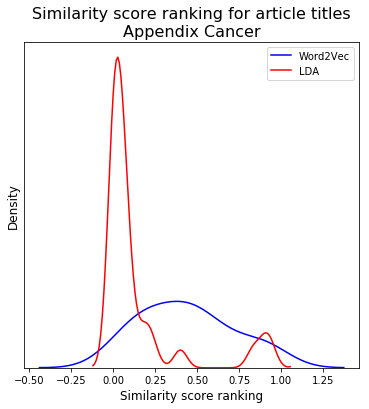

In [27]:
for cancer_type in cancer_types:
    plot_lda_w2v_similarity_rank(cancer_type)

In [50]:
subset_df.head()

,text
name,
Alexandra S. Heerdt,I am a board-certified surgeon with clinical e...
Anas Younes,I am a medical oncologist with more than 25 ye...
Ariela Noy,I am aboard-certified medical oncologist and h...
Atif J. Khan,I am a radiation oncologist who specializes in...
Beatriz Korc-Grodzicki,"As the first Chief of the Geriatrics Service, ..."
